# Nashville SC - Data Analyst - Application Project

In [1694]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.lines import Line2D
from mplsoccer import Pitch, VerticalPitch, FontManager
from functools import reduce
from sklearn.linear_model import LinearRegression
from scipy import stats
import math
from mplsoccer import PyPizza, add_image, FontManager

import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

## Exercise 1
It’s Tuesday night, November 23rd, 2021 - Nashville SC has just defeated Orlando City SC 3-1 in the first round of the Playoffs. The team has training tomorrow to prepare for the upcoming match on Sunday vs. Philadelphia Union. The Head Coach has asked you for the following:

1. Review of match vs. Orlando City SC
What tactical trends for Nashville SC were evidenced by data? Include both positive and critical insights.

2. Opposition report for next match vs. Philadelphia Union
What data-supported insights can you provide to aid in preparation for the opponent? Include both team and individual player insights.

3. Set-piece report for next match vs. Philadelphia Union
What are some statistical trends for the opponent’s set piece behavior?

### 1. Review of match vs. Orlando City SC What tactical trends for Nashville SC were evidenced by data? Include both positive and critical insights.

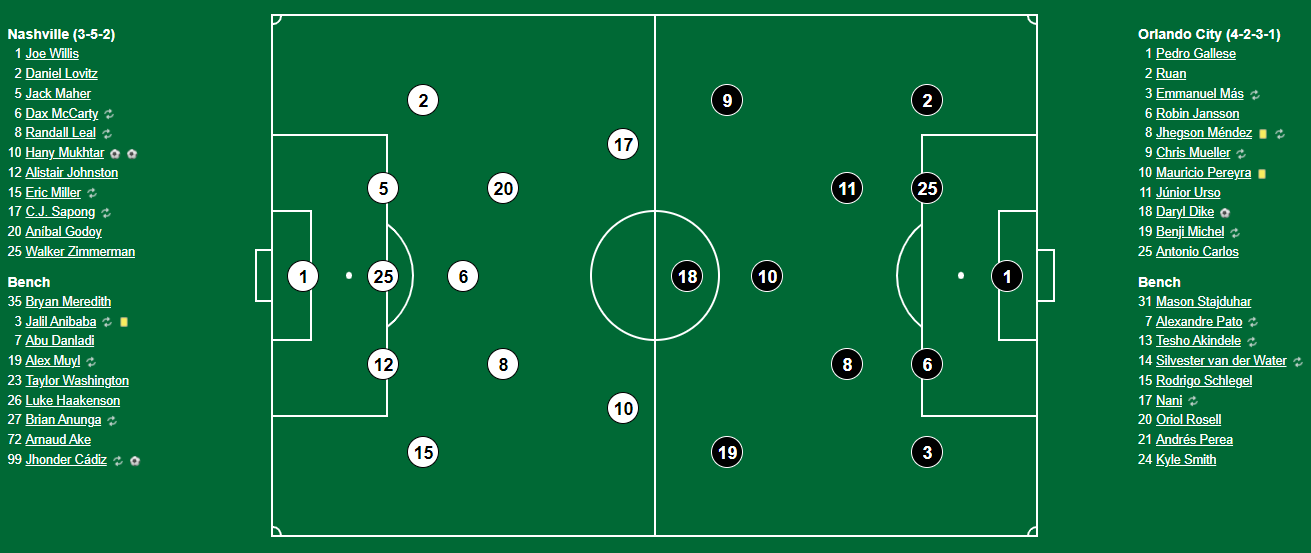



Nashville began the match set up in a 3-5-2 formation. CJ Sapong and Hany Mukhtar led the attack while Anibal Godgy, Randall Leal, and Dax McCarty made up the central midfield, with McCarty as the single pivot. Daniel Lovitz and Eric Miller provided the width as the two wing backs while the center back trio was composed of Alistair Johnston, Walker Zimmermamn, and Jack Maher.

Meanwhile Orlando set up in a more conventional 4-2-3-1 with Daryl Dike as the lone striker, accompanied by Benji Michel and Chris Mueller on the wings. The midfiled trio was composed of Mauricio Pereyra as the 10, with a double pivot of Junior Urso and Jhegson Mendez. Ruan, Robin Jansson, Emmanuel Mas, and Antonio Carlos made up the back line.

### Shooting Trends

In [61]:
shots_df1 = pd.read_csv("Data\half-1-shot-data.csv")
shots_df1['Player'] = shots_df1['Player'].str.split('\\', expand=True)
shots_df2 = pd.read_csv('Data/half-2-shot-data.csv')
shots_df2['Player'] = shots_df2['Player'].str.split('\\', expand=True)

shots_df = pd.concat([shots_df1, shots_df2])

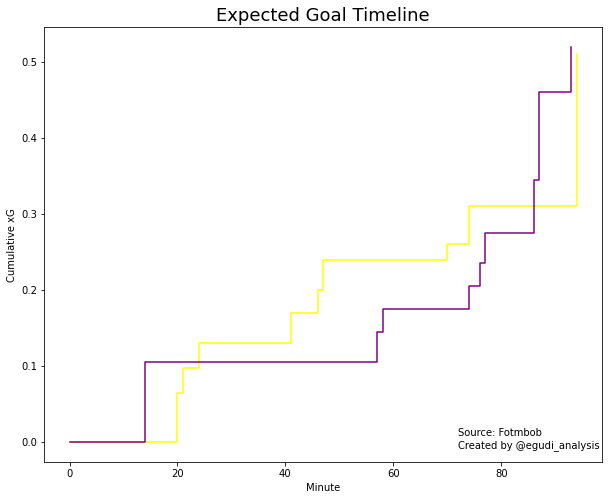

In [1595]:
shots_df['xG'] = [0.105,0.064,0.034,0.032,0.04,0.03,0.04,0.04,0.03,0.02,0.03,0.05,0.03,0.04,0,0.07,0.115,0.06,0.20]

nashville_xg = shots_df[shots_df['Squad'] == 'Nashville']
orlando_xg = shots_df[shots_df['Squad'] == 'Orlando City']

n_xG = [0]
o_xG = [0]
n_min = [0]
o_min = [0]

for index, row in nashville_xg.iterrows():
    n_xG.append(row['xG'])
    n_min.append(row['Minute'])
    
for index, row in orlando_xg.iterrows():
    o_xG.append(row['xG'])
    o_min.append(row['Minute'])

def nums_cumulative_sum(nums_list):
    return [sum(nums_list[:i+1]) for i in range(len(nums_list))]

nashville_cumulative = nums_cumulative_sum(n_xG)
nashville_cum = nashville_cumulative[1:]
orlando_cumulative = nums_cumulative_sum(o_xG)
orlando_cum = orlando_cumulative[1:]

nashville_xg['cum_xG'] = nashville_cum
orlando_xg['cum_xG'] = orlando_cum

fig, ax = plt.subplots(figsize=(10,8))
fig.set_facecolor('white')

ax.step(x=n_min, y=nashville_cumulative, where='post', label='Nashville', c='yellow')
ax.step(x=o_min, y=orlando_cumulative, where='post', label='Orlando', c='purple')
ax.set_title('Expected Goal Timeline', fontsize=18)
ax.set_xlabel('Minute')
ax.set_ylabel('Cumulative xG')

CREDIT_1 = 'Source: Fotmbob'
CREDIT_2 = 'Created by @egudi_analysis'
fig.text(0.7,0.15, f'{CREDIT_1}\n{CREDIT_2}')

plt.savefig('xG-timeline.png')

In terms of expected goals accumulated throughout the game, Nashville slightly outperformed Orlando for majority of the game while Orlanda edged out in the end with a couple medium quality chances.

In [392]:
shots_df_nsc = shots_df[shots_df['Squad'] == 'Nashville']
shots_df_orl = shots_df[shots_df['Squad'] == 'Orlando City']

In [457]:
shots_ev_nsc = shots_df_nsc.groupby('Event').agg({'Event': ['count']})
shots_ev_nsc.columns = ['Count']
shots_ev_nsc = shots_ev_nsc.reset_index()

shots_ev_nsc2 = shots_df_nsc.groupby('Event.1').agg({'Event.1': ['count']})
shots_ev_nsc2.columns = ['Count2']
shots_ev_nsc2 = shots_ev_nsc2.reset_index()
shots_ev_nsc2 = shots_ev_nsc2.rename({'Event.1': 'Event'}, axis=1)

sca_nsc = pd.merge(shots_ev_nsc, shots_ev_nsc2, on='Event', how='outer')
sca_nsc = sca_nsc.fillna(value=0)
sca_nsc['Total Events'] = sca_nsc.Count + sca_nsc['Count2']

shots_ev_orl = shots_df_orl.groupby('Event').agg({'Event': ['count']})
shots_ev_orl.columns = ['Count']
shots_ev_orl = shots_ev_orl.reset_index()

shots_ev_orl2 = shots_df_orl.groupby('Event.1').agg({'Event.1': ['count']})
shots_ev_orl2.columns = ['Count2']
shots_ev_orl2 = shots_ev_orl2.reset_index()
shots_ev_orl2 = shots_ev_orl2.rename({'Event.1': 'Event'}, axis=1)

sca_orl = pd.merge(shots_ev_orl, shots_ev_orl2, on='Event', how='outer')
sca_orl = sca_orl.fillna(value=0)
sca_orl['Total Events'] = sca_orl.Count + sca_nsc['Count2']

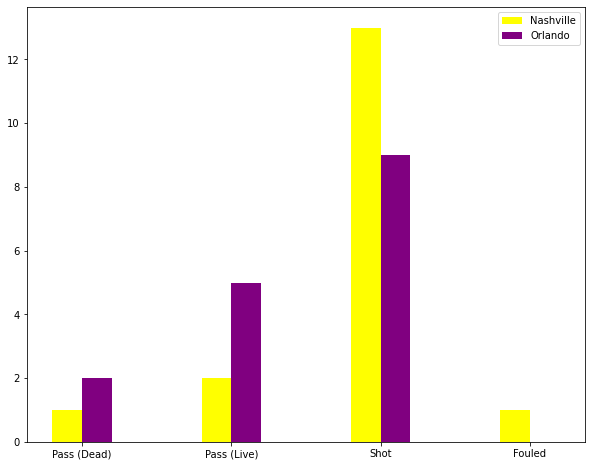

In [478]:
fig, ax = plt.subplots(figsize=(10,8))

x1 = np.arange(len(sca_nsc.Event.unique()))
x2 = np.arange(len(sca_orl.Event.unique()))

ax.bar(x1-0.1, sca_nsc['Total Events'], width=0.2, color='yellow', align='center', label='Nashville')
ax.bar(x2+0.1, sca_orl['Total Events'], width=0.2, color='purple', align = 'center', label='Orlando')

ax.legend()

ax.set_xticks(x1)
ax.set_xticklabels(sca_orl.Event.unique());

Looking at shot creating actions, Nashville relied heavily on shots while Orlando's actions were split evenly between shots and dead and live passes.

In [491]:
shots_bp_nsc = shots_df_nsc.groupby('Body Part').agg({'Body Part': ['count']})
shots_bp_nsc.columns = ['Count']
shots_bp_nsc = shots_bp_nsc.reset_index()

shots_bp_orl = shots_df_orl.groupby('Body Part').agg({'Body Part': ['count']})
shots_bp_orl.columns = ['Count']
shots_bp_orl = shots_bp_orl.reset_index()

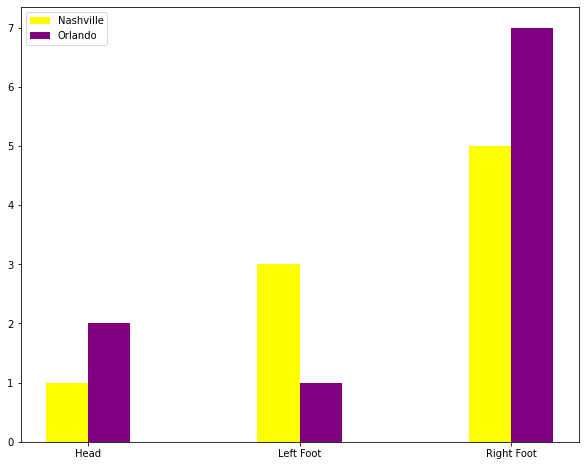

In [496]:
fig, ax = plt.subplots(figsize=(10,8))

x1 = np.arange(len(shots_bp_nsc['Body Part'].unique()))
x2 = np.arange(len(shots_bp_orl['Body Part'].unique()))

ax.bar(x1-0.1, shots_bp_nsc['Count'], width=0.2, color='yellow', align='center', label='Nashville')
ax.bar(x2+0.1, shots_bp_orl['Count'], width=0.2, color='purple', align = 'center', label='Orlando')

ax.legend()

ax.set_xticks(x1)
ax.set_xticklabels(shots_bp_nsc['Body Part'].unique());

### Pressing Trends

In [322]:
nsc_def = pd.read_csv('Data/nashville-def-stats.csv', header=1)
nsc_def['Player'] = nsc_def['Player'].str.split('\\', expand=True)
nsc_def = nsc_def.astype({'Tkl': 'float',
                        'TklW': 'float',
                        'Def 3rd': 'float',
                        'Mid 3rd': 'float',
                        'Att 3rd': 'float',
                        'Tkl': 'float',
                        'Att': 'float',
                        'Tkl%': 'float',
                        'Past': 'float',
                        'Press': 'float',
                        'Succ': 'float',
                        '%': 'float',
                        'Def 3rd': 'float',
                        'Mid 3rd': 'float', 
                        'Att 3rd': 'float',
                        'Blocks': 'float',
                        'Sh': 'float',
                        'ShSv': 'float',
                        'Pass': 'float',
                        'Int': 'float',
                        'Tkl+Int': 'float',
                        'Clr': 'float',
                        'Err': 'float',
                        'Succ': 'float'})

orl_def = pd.read_csv('Data/orlando-def-stats.csv', header=1)
orl_def['Player'] = orl_def['Player'].str.split('\\', expand=True)
orl_def = orl_def.astype({'Tkl': 'float',
                        'TklW': 'float',
                        'Def 3rd': 'float',
                        'Mid 3rd': 'float',
                        'Att 3rd': 'float',
                        'Tkl': 'float',
                        'Att': 'float',
                        'Tkl%': 'float',
                        'Past': 'float',
                        'Press': 'float',
                        'Succ': 'float',
                        '%': 'float',
                        'Def 3rd': 'float',
                        'Mid 3rd': 'float', 
                        'Att 3rd': 'float',
                        'Blocks': 'float',
                        'Sh': 'float',
                        'ShSv': 'float',
                        'Pass': 'float',
                        'Int': 'float',
                        'Tkl+Int': 'float',
                        'Clr': 'float',
                        'Err': 'float',
                        'Succ': 'float'})

In [327]:
lst = ['Interceptions', 'Tackles', 'Pressures', 'Fouls', 'PAPI', 'PAPT', 'PAPF', 'PAPPA', 'Press Regain %', 'xGA']
a = nsc_def.Int.sum() 
b = nsc_def.Tkl.sum()
c = nsc_ps.Press.sum()
d = round(orl_ps.Att.sum() / a, 1)
e = round(orl_ps.Att.sum() / b, 1)
f = round(orl_ps.Att.sum() / 18, 1)
g = round(orl_ps.Att.sum() / (a+b+18), 1)
h = round((nsc_def['Succ'].sum() / c)*100, 1)
i = 0.52
input = [a, b, c, 16, d, e, f, g, h, i]
nashville_d = pd.DataFrame({'Stat': lst,
                            'Nashville': input})

In [328]:
lst = ['Interceptions', 'Tackles', 'Pressures', 'Fouls', 'PAPI', 'PAPT', 'PAPF', 'PAPPA', 'Press Regain %', 'xGA']
a = orl_def.Int.sum() 
b = orl_def.Tkl.sum()
c = orl_ps.Press.sum()
d = round(nsc_ps.Att.sum() / a, 2)
e = round(nsc_ps.Att.sum() / b, 2)
f = round(nsc_ps.Att.sum() / 17, 2)
g = round(nsc_ps.Att.sum() / (a+b+17), 2)
h = round((orl_def['Succ'].sum() / c)*100, 1)
i = 0.51
input = [a, b, c, 17, d, e, f, g, h, i]
orlando_d = pd.DataFrame({'Stat': lst,
                            'Orlando': input})

In [329]:
nash_press_coor = pd.DataFrame({'Third': ['Att 3rd', 'Mid 3rd', 'Def 3rd'],
                           'x': [100, 60, 20],
                           'y': [40, 40, 40]})

orl_press_coor = nash_press_coor

nash_press_coor = nash_press_coor.append([nash_press_coor[nash_press_coor['Third'] == 'Att 3rd']] * 13, ignore_index=True)
nash_press_coor = nash_press_coor.append([nash_press_coor[nash_press_coor['Third'] == 'Mid 3rd']] * 66, ignore_index=True)
nash_press_coor = nash_press_coor.append([nash_press_coor[nash_press_coor['Third'] == 'Def 3rd']] * 46, ignore_index=True)

orl_press_coor = orl_press_coor.append([orl_press_coor[orl_press_coor['Third'] == 'Att 3rd']] * 35, ignore_index=True)
orl_press_coor = orl_press_coor.append([orl_press_coor[orl_press_coor['Third'] == 'Mid 3rd']] * 45, ignore_index=True)
orl_press_coor = orl_press_coor.append([orl_press_coor[orl_press_coor['Third'] == 'Def 3rd']] * 32, ignore_index=True)

In [330]:
def_metrics = pd.merge(orlando_d, nashville_d, on='Stat', how='outer')
def_metrics

,Stat,Orlando,Nashville
0,Interceptions,13.00,16.00
1,Tackles,10.00,18.00
2,Pressures,115.00,128.00
3,Fouls,17.00,16.00
4,PAPI,31.46,30.20
5,PAPT,40.90,26.80
6,PAPF,24.06,26.80
7,PAPPA,10.22,9.30
8,Press Regain %,22.60,36.70
9,xGA,0.51,0.52


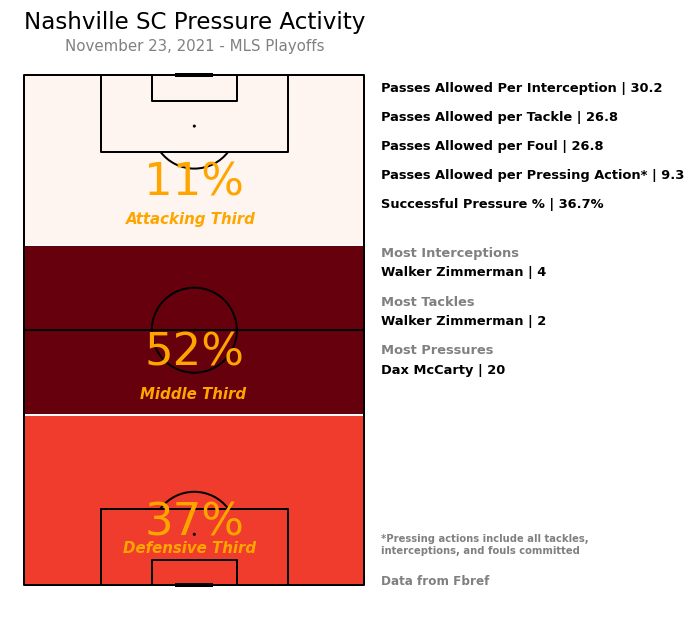

In [1596]:
pitch = VerticalPitch(pitch_type='statsbomb',
              pitch_color='white',
              line_color='black',
              line_zorder=2,
              linewidth=2)

fig, ax = pitch.grid(endnote_height=0.03, endnote_space=0,
                     title_height=0.08, title_space=0,
                     axis=False,
                     grid_height=0.84)
fig.set_facecolor('white')

bin_statistic = pitch.bin_statistic(nash_press_coor.x, nash_press_coor.y, statistic='count', bins=(3, 1), normalize=True)

pitch.heatmap(bin_statistic, ax=ax['pitch'], cmap='Reds', edgecolor='#f9f9f9')

labels = pitch.label_heatmap(bin_statistic, color='orange', fontsize=45,
                             ax=ax['pitch'], ha='center', va='top',
                             str_format='{:.0%}')

ax['endnote'].text(0.30, 20.5, 'Attacking Third', 
                   weight='bold', style='italic', fontsize=15, color='orange')

ax['endnote'].text(0.34, 11.5, 'Middle Third', 
                   weight='bold', style='italic', fontsize=15, color='orange')

ax['endnote'].text(0.29, 3.6, 'Defensive Third', 
                   weight='bold', style='italic', fontsize=15, color='orange')

ax['endnote'].text(1.05, 2.13, 'Data from Fbref', color='gray',
                   va='center', ha='left', fontsize=12, weight='bold')

ax['endnote'].text(1.05, 4, '*Pressing actions include all tackles,\ninterceptions, and fouls committed', color='gray',
                   va='center', ha='left', fontsize=10, weight='bold')

ax['endnote'].text(1.05, 27.5, f"Passes Allowed Per Interception | {def_metrics.loc[4, 'Nashville']}", color='black',
                   va='center', ha='left', fontsize=13, weight='bold')

ax['endnote'].text(1.05, 26, f"Passes Allowed per Tackle | {def_metrics.loc[5, 'Nashville']}", color='black',
                   va='center', ha='left', fontsize=13, weight='bold')

ax['endnote'].text(1.05, 24.5, f"Passes Allowed per Foul | {def_metrics.loc[6, 'Nashville']}", color='black',
                   va='center', ha='left', fontsize=13, weight='bold')

ax['endnote'].text(1.05, 23, f"Passes Allowed per Pressing Action* | {def_metrics.loc[7, 'Nashville']}", color='black',
                   va='center', ha='left', fontsize=13, weight='bold')

ax['endnote'].text(1.05, 21.5, f"Successful Pressure % | {def_metrics.loc[8, 'Nashville']}%", color='black',
                   va='center', ha='left', fontsize=13, weight='bold')

ax['endnote'].text(1.05, 19, 'Most Interceptions', color='gray',
                   va='center', ha='left', fontsize=13, weight='bold')

ax['endnote'].text(1.05, 18, 'Walker Zimmerman | 4', color='black',
                   va='center', ha='left', fontsize=13, weight='bold')

ax['endnote'].text(1.05, 16.5, 'Most Tackles', color='gray',
                   va='center', ha='left', fontsize=13, weight='bold')

ax['endnote'].text(1.05, 15.5, 'Walker Zimmerman | 2', color='black',
                   va='center', ha='left', fontsize=13, weight='bold')

ax['endnote'].text(1.05, 14, 'Most Pressures', color='gray',
                   va='center', ha='left', fontsize=13, weight='bold')

ax['endnote'].text(1.05, 13, 'Dax McCarty | 20', color='black',
                   va='center', ha='left', fontsize=13, weight='bold')

# title
ax['title'].text(0.5, 0.7, 'Nashville SC Pressure Activity', color='black', va='center', ha='center', fontsize=23)

# subtitle
ax['title'].text(0.5, 0.25, 'November 23, 2021 - MLS Playoffs', color='gray', va='center', ha='center', fontsize=15);

plt.savefig('nashville-pressure-activity.png')

The vast majority of Nashville's pressing activity (52%) occurred in the middle third of the field. Only 11% of their pressures occured in the attacking third suggesting Nashville remained a fairly conservative defensive line. This allowed Orlando to keep the ball in their defensive third, thus enjoying the vast majority of the possession throughout the game. Nashville's press was slightly more intense than Orlando's, given a lower amount of passes allowed per pressing action, as the press intensified once Orlando entered the middle third of the field. Additionally, Nashville press was more successful than Orlando's as they recovered the ball 36.7% of the time in which they pressed, compared to 22.6%.

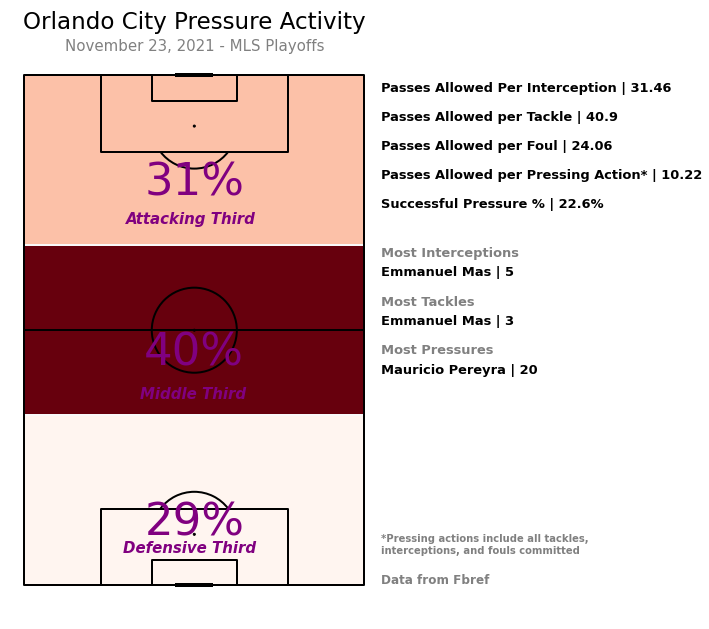

In [1597]:
pitch = VerticalPitch(pitch_type='statsbomb',
              pitch_color='white',
              line_color='black',
              line_zorder=2,
              linewidth=2)

fig, ax = pitch.grid(endnote_height=0.03, endnote_space=0,
                     title_height=0.08, title_space=0,
                     axis=False,
                     grid_height=0.84)
fig.set_facecolor('white')

bin_statistic = pitch.bin_statistic(orl_press_coor.x, orl_press_coor.y, statistic='count', bins=(3, 1), normalize=True)

pitch.heatmap(bin_statistic, ax=ax['pitch'], cmap='Reds', edgecolor='#f9f9f9')

labels = pitch.label_heatmap(bin_statistic, color='purple', fontsize=45,
                             ax=ax['pitch'], ha='center', va='top',
                             str_format='{:.0%}')

ax['endnote'].text(0.30, 20.5, 'Attacking Third', 
                   weight='bold', style='italic', fontsize=15, color='purple')

ax['endnote'].text(0.34, 11.5, 'Middle Third', 
                   weight='bold', style='italic', fontsize=15, color='purple')

ax['endnote'].text(0.29, 3.6, 'Defensive Third', 
                   weight='bold', style='italic', fontsize=15, color='purple')

ax['endnote'].text(1.05, 2.18, 'Data from Fbref', color='gray',
                   va='center', ha='left', fontsize=12, weight='bold')

ax['endnote'].text(1.05, 4, '*Pressing actions include all tackles,\ninterceptions, and fouls committed', color='gray',
                   va='center', ha='left', fontsize=10, weight='bold')

ax['endnote'].text(1.05, 27.5, f"Passes Allowed Per Interception | {def_metrics.loc[4, 'Orlando']}", color='black',
                   va='center', ha='left', fontsize=13, weight='bold')

ax['endnote'].text(1.05, 26, f"Passes Allowed per Tackle | {def_metrics.loc[5, 'Orlando']}", color='black',
                   va='center', ha='left', fontsize=13, weight='bold')

ax['endnote'].text(1.05, 24.5, f"Passes Allowed per Foul | {def_metrics.loc[6, 'Orlando']}", color='black',
                   va='center', ha='left', fontsize=13, weight='bold')

ax['endnote'].text(1.05, 23, f"Passes Allowed per Pressing Action* | {def_metrics.loc[7, 'Orlando']}", color='black',
                   va='center', ha='left', fontsize=13, weight='bold')

ax['endnote'].text(1.05, 21.5, f"Successful Pressure % | {def_metrics.loc[8, 'Orlando']}%", color='black',
                   va='center', ha='left', fontsize=13, weight='bold')

ax['endnote'].text(1.05, 19, 'Most Interceptions', color='gray',
                   va='center', ha='left', fontsize=13, weight='bold')

ax['endnote'].text(1.05, 18, 'Emmanuel Mas | 5', color='black',
                   va='center', ha='left', fontsize=13, weight='bold')

ax['endnote'].text(1.05, 16.5, 'Most Tackles', color='gray',
                   va='center', ha='left', fontsize=13, weight='bold')

ax['endnote'].text(1.05, 15.5, 'Emmanuel Mas | 3', color='black',
                   va='center', ha='left', fontsize=13, weight='bold')

ax['endnote'].text(1.05, 14, 'Most Pressures', color='gray',
                   va='center', ha='left', fontsize=13, weight='bold')

ax['endnote'].text(1.05, 13, 'Mauricio Pereyra | 20', color='black',
                   va='center', ha='left', fontsize=13, weight='bold')

# title
ax['title'].text(0.5, 0.7, 'Orlando City Pressure Activity', color='black', va='center', ha='center', fontsize=23)

# subtitle
ax['title'].text(0.5, 0.25, 'November 23, 2021 - MLS Playoffs', color='gray', va='center', ha='center', fontsize=15);

plt.savefig('orlando-pressure-activity.png')

In contrast, Orlando's pressure activity was more evenly distributed across the pitch, with the majority occuring in the middle and attacking third. This suggests Orlando maintained a higher line and attempted to press higher up the pitch; however, the press was slightly less intense, given a greater value of passes allowed per pressing action. Furthermore, Nashville was able to more consistantly beat the higher press as Orlando only gained possesion 22.6% of the time in which they pressed.

In [360]:
nsc_poss = pd.read_csv('Data/nashville-possession.csv')
nsc_poss['Player'] = nsv_poss['Player'].str.split('\\', expand=True)

orl_poss = pd.read_csv('Data/orlando-possession.csv')
orl_poss['Player'] = orl_poss['Player'].str.split('\\', expand=True)

In [380]:
lst = ['Live Touches', 'Progressive Carries', 'Progressive Distance Covered', 'Carries Att 3rd', 'Carries Into Box', 'Progressive Passes']
a = nsc_poss.Live.sum() 
b = nsc_poss.Prog.sum()
c = nsc_poss.PrgDist.sum()
d = nsc_poss['1/3'].sum()
e = nsc_poss.CPA.sum()
f = nsc_poss['Prog.1'].sum()

data = [a, b, c, d, e, f]
nashville_p = pd.DataFrame({'Stat': lst,
                            'Nashville': data})

In [383]:
lst = ['Live Touches', 'Progressive Carries', 'Progressive Distance Covered', 'Carries Att 3rd', 'Carries Into Box', 'Progressive Passes']
a = orl_poss.Live.sum() 
b = orl_poss.Prog.sum()
c = orl_poss.PrgDist.sum()
d = orl_poss['1/3'].sum()
e = orl_poss.CPA.sum()
f = orl_poss['Prog.1'].sum()

data = [a, b, c, d, e, f]
orlando_p = pd.DataFrame({'Stat': lst,
                          'Orlando': data})

In [384]:
poss_metrics = pd.merge(orlando_p, nashville_p, on='Stat', how='outer')
poss_metrics

,Stat,Orlando,Nashville
0,Live Touches,539,472
1,Progressive Carries,43,27
2,Progressive Distance Covered,935,1003
3,Carries Att 3rd,15,9
4,Carries Into Box,6,3
5,Progressive Passes,28,28


In [378]:
nash_touch_coor = pd.DataFrame({'Third': ['Att 3rd', 'Mid 3rd', 'Def 3rd'],
                           'x': [100, 60, 20],
                           'y': [40, 40, 40]})

orl_touch_coor = nash_touch_coor

nash_touch_coor = nash_touch_coor.append([nash_touch_coor[nash_touch_coor['Third'] == 'Att 3rd']] * 93, ignore_index=True)
nash_touch_coor = nash_touch_coor.append([nash_touch_coor[nash_touch_coor['Third'] == 'Mid 3rd']] * 251, ignore_index=True)
nash_touch_coor = nash_touch_coor.append([nash_touch_coor[nash_touch_coor['Third'] == 'Def 3rd']] * 194, ignore_index=True)

orl_touch_coor = orl_touch_coor.append([orl_touch_coor[orl_touch_coor['Third'] == 'Att 3rd']] * 156, ignore_index=True)
orl_touch_coor = orl_touch_coor.append([orl_touch_coor[orl_touch_coor['Third'] == 'Mid 3rd']] * 305, ignore_index=True)
orl_touch_coor = orl_touch_coor.append([orl_touch_coor[orl_touch_coor['Third'] == 'Def 3rd']] * 164, ignore_index=True)

In [379]:
len(orl_touch_coor), len(nash_touch_coor)

(628, 541)

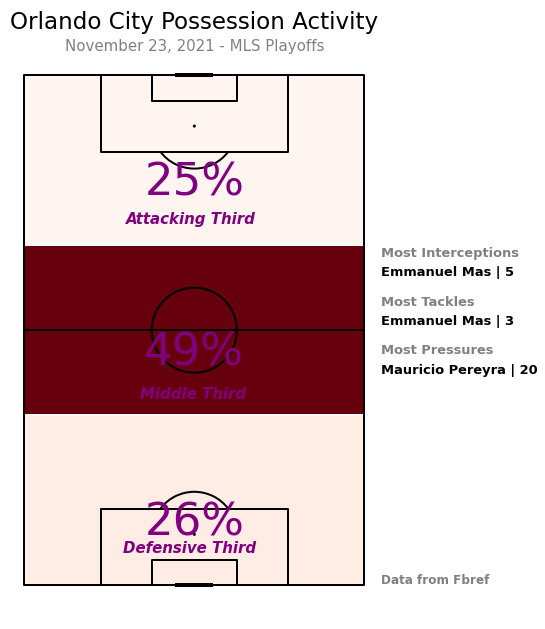

In [386]:
pitch = VerticalPitch(pitch_type='statsbomb',
              pitch_color='white',
              line_color='black',
              line_zorder=2,
              linewidth=2)

fig, ax = pitch.grid(endnote_height=0.03, endnote_space=0,
                     title_height=0.08, title_space=0,
                     axis=False,
                     grid_height=0.84)
fig.set_facecolor('white')

bin_statistic = pitch.bin_statistic(orl_touch_coor.x, orl_touch_coor.y, statistic='count', bins=(3, 1), normalize=True)

pitch.heatmap(bin_statistic, ax=ax['pitch'], cmap='Reds', edgecolor='#f9f9f9')

labels = pitch.label_heatmap(bin_statistic, color='purple', fontsize=45,
                             ax=ax['pitch'], ha='center', va='top',
                             str_format='{:.0%}')

ax['endnote'].text(0.30, 20.5, 'Attacking Third', 
                   weight='bold', style='italic', fontsize=15, color='purple')

ax['endnote'].text(0.34, 11.5, 'Middle Third', 
                   weight='bold', style='italic', fontsize=15, color='purple')

ax['endnote'].text(0.29, 3.6, 'Defensive Third', 
                   weight='bold', style='italic', fontsize=15, color='purple')

ax['endnote'].text(1.05, 2.18, 'Data from Fbref', color='gray',
                   va='center', ha='left', fontsize=12, weight='bold')

ax['endnote'].text(1.05, 19, 'Most Interceptions', color='gray',
                   va='center', ha='left', fontsize=13, weight='bold')

ax['endnote'].text(1.05, 18, 'Emmanuel Mas | 5', color='black',
                   va='center', ha='left', fontsize=13, weight='bold')

ax['endnote'].text(1.05, 16.5, 'Most Tackles', color='gray',
                   va='center', ha='left', fontsize=13, weight='bold')

ax['endnote'].text(1.05, 15.5, 'Emmanuel Mas | 3', color='black',
                   va='center', ha='left', fontsize=13, weight='bold')

ax['endnote'].text(1.05, 14, 'Most Pressures', color='gray',
                   va='center', ha='left', fontsize=13, weight='bold')

ax['endnote'].text(1.05, 13, 'Mauricio Pereyra | 20', color='black',
                   va='center', ha='left', fontsize=13, weight='bold')

# title
ax['title'].text(0.5, 0.7, 'Orlando City Possession Activity', color='black', va='center', ha='center', fontsize=23)

# subtitle
ax['title'].text(0.5, 0.25, 'November 23, 2021 - MLS Playoffs', color='gray', va='center', ha='center', fontsize=15);

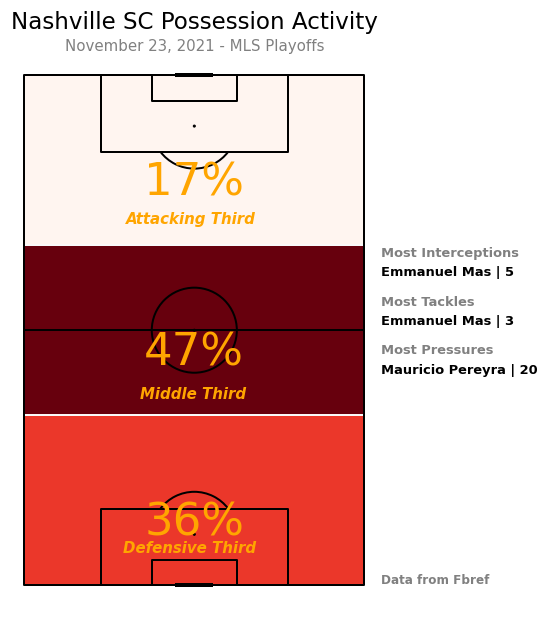

In [388]:
pitch = VerticalPitch(pitch_type='statsbomb',
              pitch_color='white',
              line_color='black',
              line_zorder=2,
              linewidth=2)

fig, ax = pitch.grid(endnote_height=0.03, endnote_space=0,
                     title_height=0.08, title_space=0,
                     axis=False,
                     grid_height=0.84)
fig.set_facecolor('white')

bin_statistic = pitch.bin_statistic(nash_touch_coor.x, nash_touch_coor.y, statistic='count', bins=(3, 1), normalize=True)

pitch.heatmap(bin_statistic, ax=ax['pitch'], cmap='Reds', edgecolor='#f9f9f9')

labels = pitch.label_heatmap(bin_statistic, color='orange', fontsize=45,
                             ax=ax['pitch'], ha='center', va='top',
                             str_format='{:.0%}')

ax['endnote'].text(0.30, 20.5, 'Attacking Third', 
                   weight='bold', style='italic', fontsize=15, color='orange')

ax['endnote'].text(0.34, 11.5, 'Middle Third', 
                   weight='bold', style='italic', fontsize=15, color='orange')

ax['endnote'].text(0.29, 3.6, 'Defensive Third', 
                   weight='bold', style='italic', fontsize=15, color='orange')

ax['endnote'].text(1.05, 2.18, 'Data from Fbref', color='gray',
                   va='center', ha='left', fontsize=12, weight='bold')

ax['endnote'].text(1.05, 19, 'Most Interceptions', color='gray',
                   va='center', ha='left', fontsize=13, weight='bold')

ax['endnote'].text(1.05, 18, 'Emmanuel Mas | 5', color='black',
                   va='center', ha='left', fontsize=13, weight='bold')

ax['endnote'].text(1.05, 16.5, 'Most Tackles', color='gray',
                   va='center', ha='left', fontsize=13, weight='bold')

ax['endnote'].text(1.05, 15.5, 'Emmanuel Mas | 3', color='black',
                   va='center', ha='left', fontsize=13, weight='bold')

ax['endnote'].text(1.05, 14, 'Most Pressures', color='gray',
                   va='center', ha='left', fontsize=13, weight='bold')

ax['endnote'].text(1.05, 13, 'Mauricio Pereyra | 20', color='black',
                   va='center', ha='left', fontsize=13, weight='bold')

# title
ax['title'].text(0.5, 0.7, 'Nashville SC Possession Activity', color='black', va='center', ha='center', fontsize=23)

# subtitle
ax['title'].text(0.5, 0.25, 'November 23, 2021 - MLS Playoffs', color='gray', va='center', ha='center', fontsize=15);

### Passing Trends

In [516]:
nsc_passing = pd.read_csv('Data/nashville-passing.csv')
nsc_passing['Player'] = nsc_passing['Player'].str.split('\\', expand=True)
nsc_pass = nsc_passing[['Player', 'Prog']]
nsc_carry = nsc_poss[['Player', 'Prog']]
nsc_prog = pd.merge(nsc_pass, nsc_carry, on='Player', how='outer')

orl_passing = pd.read_csv('Data/orlando-passing.csv')
orl_passing['Player'] = orl_passing['Player'].str.split('\\', expand=True)
orl_pass = orl_passing[['Player', 'Prog']]
orl_carry = orl_poss[['Player', 'Prog']]
orl_prog = pd.merge(orl_pass, orl_carry, on='Player', how='outer')

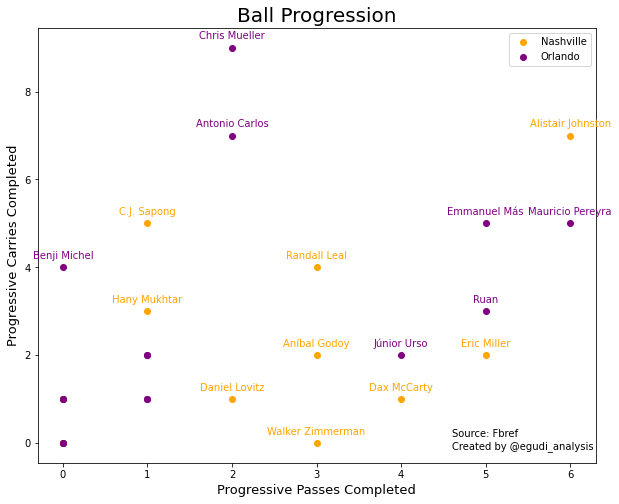

In [1599]:
fig, ax = plt.subplots(figsize=(10,8))

ax.scatter(nsc_prog['Prog_x'], nsc_prog['Prog_y'], color='orange', label='Nashville')
ax.scatter(orl_prog['Prog_x'], orl_prog['Prog_y'], color='purple', label='Orlando')

ax.legend()

for index, row in nsc_prog.iterrows():
    if row['Prog_x'] > 0:
        ax.annotate(row.Player, xy=([row['Prog_x'], row['Prog_y']+0.2]), ha='center', color='orange')
        
for index, row in orl_prog.iterrows():
    if row['Prog_y'] > 2 or row.Player == 'Júnior Urso':
        ax.annotate(row.Player, xy=([row['Prog_x'], row['Prog_y']+0.2]), ha='center', color='purple')
        
ax.set_xlabel('Progressive Passes Completed', fontsize=13)
ax.set_ylabel('Progressive Carries Completed', fontsize=13);

ax.set_title('Ball Progression', fontsize=20);

CREDIT_1 = 'Source: Fbref'
CREDIT_2 = 'Created by @egudi_analysis'
fig.text(0.7,0.15, f'{CREDIT_1}\n{CREDIT_2}')

plt.savefig('ball-progression-no.png')

In terms of ball progression, Nashville's main ball progressors were Alistair Johnson, Eric Miller, Randall Leal and CJ Sapong. Johnson was able to progress the ball frequently from a center back position, both by carrying the ball forward into space and through passes. Meanwhile Miller contributed with five progressive passes from a wing back position. CJ Sapong put up a decent amount of progressive carries, as he drove forward into dangerous zones once Nashville was in the attack. Johnson and Miller's cumulative progressive actions highlight the importance of Nashville's defenders in progressing the ball forward during counter attacks.

In [582]:
lst = ['short', 'medium', 'long']
a = round((140 / 409)*100, 1)
b = round((161 / 409)*100, 1)
c = round((97 / 409)*100, 1)
prog_per_pass = round((28 / 409)*100, 1)

data = [a, b, c]
nsc_pp = pd.DataFrame({'Pass Type': lst,
                       'Nashville': data})

In [583]:
lst = ['short', 'medium', 'long']
a = round((187 / 483)*100, 1)
b = round((192 / 483)*100, 1)
c = round((94 / 483)*100, 1)
prog_per_pass = round((28 / 483)*100)

data = [a, b, c]
orl_pp = pd.DataFrame({'Pass Type': lst,
                       'Orlando': data})

In [584]:
pass_types = pd.merge(orl_pp, nsc_pp, on='Pass Type', how='outer')

In [585]:
pass_types

,Pass Type,Orlando,Nashville
0,short,38.7,34.2
1,medium,39.8,39.4
2,long,19.5,23.7


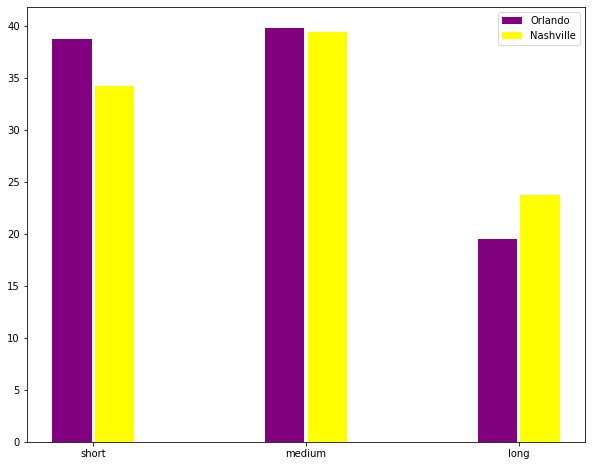

In [600]:
fig, ax = plt.subplots(figsize=(10,8))

x1 = np.arange(len(pass_types['Pass Type'].unique()))

ax.bar(x1-0.1, pass_types['Orlando'], width=0.185, color='purple', align='center', label='Orlando')
ax.bar(x1+0.1, pass_types['Nashville'], width=0.185, color='yellow', align = 'center', label='Nashville')

ax.legend()

ax.set_xticks(x1)
ax.set_xticklabels(pass_types['Pass Type'].unique());

### 2. Opposition report for next match vs. Philadelphia Union What data-supported insights can you provide to aid in preparation for the opponent? Include both team and individual player insights.

In [617]:
east_conf = pd.read_csv('Data/eastern-conference-table.csv')
west_conf = pd.read_csv('Data/western-conference.csv')
mls_table = pd.concat([east_conf, west_conf])
mls_table = mls_table.sort_values(['Pts'], ascending=False).reset_index()

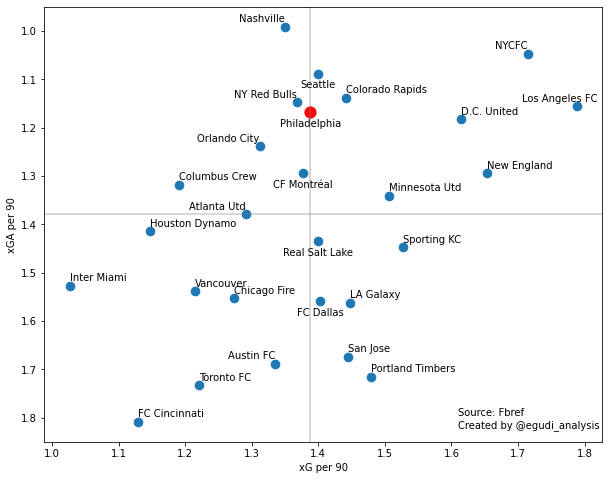

In [1600]:
mls_table['xG90'] = mls_table['xG'] / mls_table['MP']
mls_table['xGA90'] = mls_table['xGA'] / mls_table['MP']

fig, ax = plt.subplots(figsize=(10,8))
fig.set_facecolor('white')

x = mls_table.xG90
y = mls_table.xGA90

ax.scatter(x, y, s=75)
ax.scatter(1.388235, 1.167647, color='red', s=125)
ax.invert_yaxis()
ax.axvline(x=mls_table.xG90.median(), color='gray', alpha=0.4)
ax.axhline(y=mls_table.xGA90.median(), color='gray', alpha=0.4)
ax.set_xlabel('xG per 90', fontsize=10)
ax.set_ylabel('xGA per 90', fontsize=10)

for index, row in mls_table.iterrows():
    if row.xG90 > 1.7:
        ax.annotate(row.Squad, xy=([(row.xG90)-0.025, (row.xGA90)-.01]), ha='center')
    elif row.xG90 > 1.411 < 1.7:
        ax.annotate(row.Squad, xy=([row.xG90, (row.xGA90)-.01]), ha='left')
    elif row.xG90 > 1.368 < 1.411:
        ax.annotate(row.Squad, xy=([row.xG90, (row.xGA90)+.03]), ha='center')
    elif row.xG90 > 1.274 < 1.368:
        ax.annotate(row.Squad, xy=([row.xG90, (row.xGA90)-.01]), ha='right')
    else:
        ax.annotate(row.Squad, xy=([row.xG90, (row.xGA90)-.01]), ha='left')
        
CREDIT_1 = 'Source: Fbref'
CREDIT_2 = 'Created by @egudi_analysis'
fig.text(0.7,0.15, f'{CREDIT_1}\n{CREDIT_2}')

plt.savefig('league-xG-xGA.png')

Throughout the season, Philadelphia has exhibited excellent defensive metrics, given they have the sixth lowest expected goals conceded per 90 minutes. Meanwhile their chance creation, evident by their expected goals per 90 minutes, has been on par with the league median.

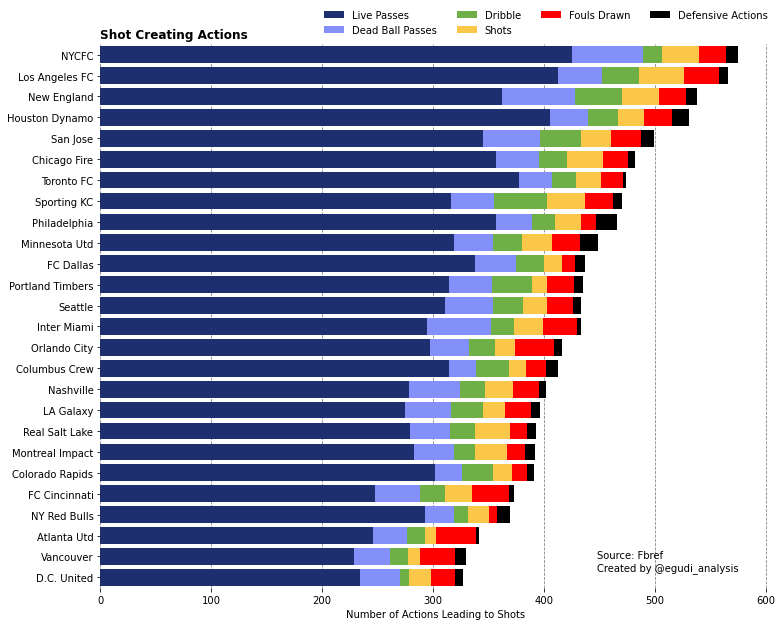

In [1601]:
shot_types = pd.read_csv('Data/shot-types.csv')

fields = ['PassLive','PassDead','Drib','Sh', 'Fld', 'Def']
colors = ['#1D2F6F', '#8390FA', '#6EAF46', '#FAC748', 'red', 'black']
labels = ['Live Passes', 'Dead Ball Passes', 'Dribble', 'Shots', 'Fouls Drawn', 'Defensive Actions']

shot_types['Sum'] = shot_types['PassLive']+shot_types['PassDead']+shot_types['Drib']+shot_types['Sh']+shot_types['Fld']+shot_types['Def']

shot_types = shot_types.sort_values('Sum', ascending=True).reset_index()

# figure and axis
fig, ax = plt.subplots(1, figsize=(12, 10))

# plot bars
left = len(shot_types) * [0]
for idx, name in enumerate(fields):
    plt.barh(shot_types.Squad, shot_types[name], left = left, color=colors[idx])
    left = left + shot_types[name]
    
# title, legend, labels
plt.title('Shot Creating Actions', loc='left', weight='bold')
plt.legend(labels, bbox_to_anchor=([0.32, 1, 0, 0]), ncol=4, frameon=False)
plt.xlabel('Number of Actions Leading to Shots')

# remove spines
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# adjust limits and draw grid lines
plt.ylim(-0.5, ax.get_yticks()[-1] + 0.5)
ax.set_axisbelow(True)
ax.xaxis.grid(color='gray', linestyle='dashed')

CREDIT_1 = 'Source: Fbref'
CREDIT_2 = 'Created by @egudi_analysis'
fig.text(0.7,0.15, f'{CREDIT_1}\n{CREDIT_2}')

plt.savefig('sca.png')

The vast majority of Philadelphia's shot creating actions came from live passes but also relied more on defensive actions relative to the rest of the league.

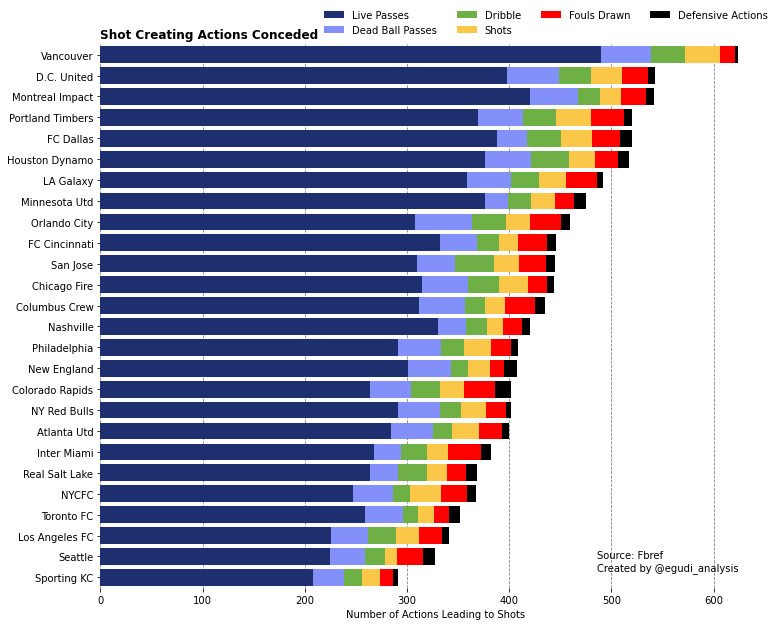

In [1602]:
shot_types_a = pd.read_csv('Data/shot-types-against.csv')

fields = ['PassLive','PassDead','Drib','Sh', 'Fld', 'Def']
colors = ['#1D2F6F', '#8390FA', '#6EAF46', '#FAC748', 'red', 'black']
labels = ['Live Passes', 'Dead Ball Passes', 'Dribble', 'Shots', 'Fouls Drawn', 'Defensive Actions']

shot_types_a['Sum'] = shot_types_a['PassLive']+shot_types_a['PassDead']+shot_types_a['Drib']+shot_types_a['Sh']+shot_types_a['Fld']+shot_types_a['Def']

shot_types_a = shot_types_a.sort_values('Sum', ascending=True).reset_index()

# figure and axis
fig, ax = plt.subplots(1, figsize=(12, 10))

# plot bars
left = len(shot_types_a) * [0]
for idx, name in enumerate(fields):
    plt.barh(shot_types_a.Squad, shot_types_a[name], left = left, color=colors[idx])
    left = left + shot_types_a[name]
    
# title, legend, labels
plt.title('Shot Creating Actions Conceded', loc='left', weight='bold')
plt.legend(labels, bbox_to_anchor=([0.32, 1, 0, 0]), ncol=4, frameon=False)
plt.xlabel('Number of Actions Leading to Shots')

# remove spines
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# adjust limits and draw grid lines
plt.ylim(-0.5, ax.get_yticks()[-1] + 0.5)
ax.set_axisbelow(True)
ax.xaxis.grid(color='gray', linestyle='dashed')

CREDIT_1 = 'Source: Fbref'
CREDIT_2 = 'Created by @egudi_analysis'
fig.text(0.7,0.15, f'{CREDIT_1}\n{CREDIT_2}')

plt.savefig('scaA.png')

In terms of shot creating actions conceded, much like the rest of leage, the actions that led to the most shots against Philadelphia occurred in open-play, followed by passes from dead balls.

### Pressing Patterns

In [1613]:
mls_def = pd.read_csv('Data/squad-def-stats.csv')
mls_pa = pd.read_csv('Data/pass-stats-conceded.csv')
mls_misc = pd.read_csv('Data/mls-misc-stats.csv')
mls_misc['Squad'] = mls_misc['Squad'].str.replace('Montreal Impact', 'CF Montréal')

In [1614]:
mls_tackles = mls_misc[['Squad', 'Fls']]
mls_pressing = mls_def[['Squad', 'Press', 'Def 3rd', 'Mid 3rd', 'Att 3rd', 'Tkl', 'Int']]
mls_paa = mls_pa[['Squad', 'Att']]
mls_paa['Squad'] = mls_paa['Squad'].str[3:]
mls_pressing = pd.merge(mls_pressing, mls_tackles, on='Squad', how='outer')
mls_pressing = pd.merge(mls_pressing, mls_paa, on='Squad', how='outer')

In [1615]:
mls_pressing['PAPT'] = mls_pressing['Att'] / mls_pressing['Tkl']
mls_pressing['PAPI'] = mls_pressing['Att'] / mls_pressing['Int']
mls_pressing['PAPPA'] = mls_pressing['Att'] / (mls_pressing['Tkl'] + mls_pressing['Int'])
mls_pressing['Press90'] = mls_pressing['Press'] / 90
mls_pressing['Tkl90'] = mls_pressing['Tkl'] / 90
mls_pressing['Int90'] = mls_pressing['Int'] / 90
mls_pressing['PassAllow90'] = mls_pressing['Att'] / 90
mls_pressing = mls_pressing.sort_values('PAPPA', ascending=False).reset_index()
mls_pressing = mls_pressing.fillna(value=round(mls_pressing.Tkl.mean(), 0))
mls_pressing['PAPPA'] = round(mls_pressing['PAPPA'],2)

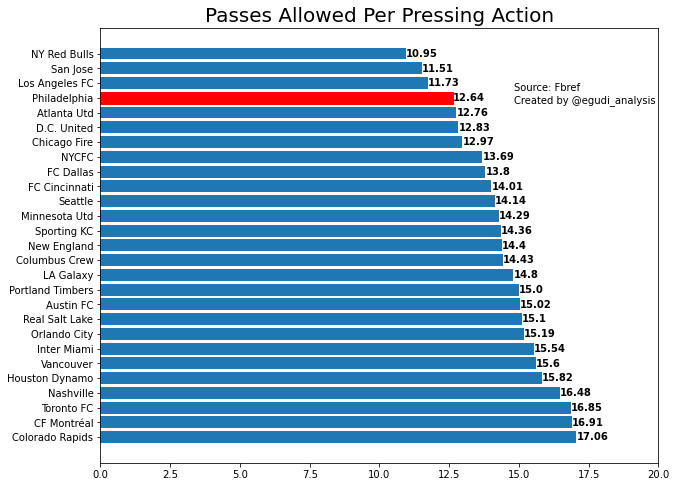

In [1616]:
fig, ax = plt.subplots(figsize=(10, 8))

y = mls_pressing.PAPPA
x = mls_pressing.Squad

ax.barh(x, y)
ax.set_xlim(left=0, right=20)
ax.get_children()[23].set_color('red')
ax.set_title('Passes Allowed Per Pressing Action', fontsize=20)

for index, row in mls_pressing.iterrows():
    ax.annotate(row.PAPPA, xy=(row.PAPPA, row.Squad), va='center', weight='bold')
    
CREDIT_1 = 'Source: Fbref'
CREDIT_2 = 'Created by @egudi_analysis'
fig.text(0.7,.75, f'{CREDIT_1}\n{CREDIT_2}')

plt.savefig('pappa.png')

In terms of pressing intensity, Philadelphia has had the fourth most intense press, evident by the fourth lowest amount of passes allowed per pressing action. This suggests that Philadelphia has employed the fourth most aggressive press througout the season.

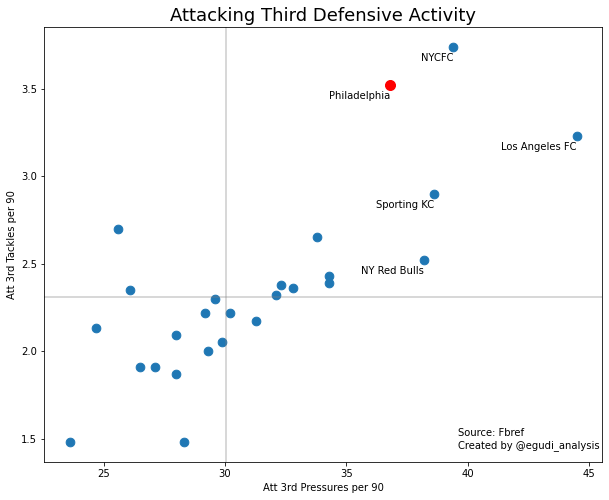

In [1617]:
pressing90 = pd.read_csv('Data/pressing-per-ninety.csv')

fig, ax = plt.subplots(figsize=(10,8))
fig.set_facecolor('white')

x = pressing90['Att 3rd.1']
y = pressing90['Att 3rd']

ax.scatter(x, y, s=75)
ax.scatter(36.8, 3.52, color='red', s=100)
ax.axvline(x=pressing90['Att 3rd.1'].median(), color='gray', alpha=0.4)
ax.axhline(y=pressing90['Att 3rd'].median(), color='gray', alpha=0.4)
ax.set_xlabel('Att 3rd Pressures per 90', fontsize=10)
ax.set_ylabel('Att 3rd Tackles per 90', fontsize=10)
ax.set_title('Attacking Third Defensive Activity', fontsize=18)

for index, row in pressing90.iterrows():
    if row['Att 3rd.1'] > 35:
        ax.annotate(row.Squad, xy=([row['Att 3rd.1'], (row['Att 3rd'])-0.08]), ha='right')
        
CREDIT_1 = 'Source: Fbref'
CREDIT_2 = 'Created by @egudi_analysis'
fig.text(0.7,0.15, f'{CREDIT_1}\n{CREDIT_2}')

plt.savefig('att-press.png')

Not only has Philadelphia been one of the most aggressive pressing teams in the league, but they are also winning the second highest amount of tackles in the attacking third as they will attempt to limit the amount of passes played in the attacking third as much as possible.

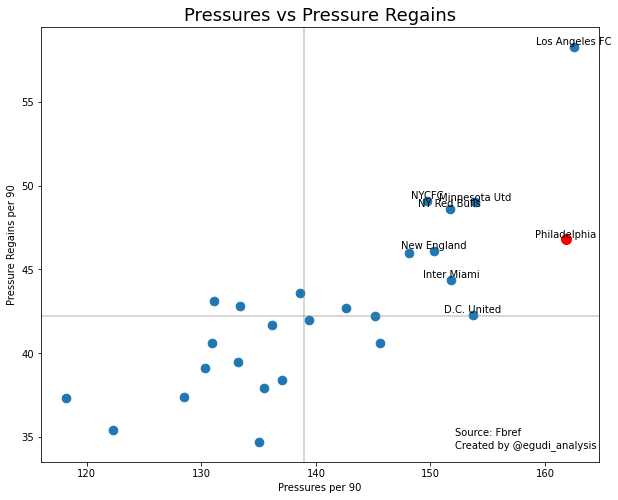

In [1618]:
fig, ax = plt.subplots(figsize=(10,8))
fig.set_facecolor('white')

x = pressing90['Press']
y = pressing90['Succ']

ax.scatter(x, y, s=75)
ax.scatter(161.8, 46.8, color='red', s=100)
ax.axvline(x=pressing90['Press'].median(), color='gray', alpha=0.4)
ax.axhline(y=pressing90['Succ'].median(), color='gray', alpha=0.4)
ax.set_xlabel('Pressures per 90', fontsize=10)
ax.set_ylabel('Pressure Regains per 90', fontsize=10)
ax.set_title('Pressures vs Pressure Regains', fontsize=18)

for index, row in pressing90.iterrows():
    if row['Press'] > 149:
        ax.annotate(row.Squad, xy=([row['Press'], (row['Succ'])]), ha='center', va='bottom')
        
CREDIT_1 = 'Source: Fbref'
CREDIT_2 = 'Created by @egudi_analysis'
fig.text(0.7,0.15, f'{CREDIT_1}\n{CREDIT_2}')

plt.savefig('pressure-regains.png')

Although Philadelphia has recorded the second highest pressures per 90, their press is not as effective as other high pressing teams such as LAFC or NY Red Bulls, evident by the amount of pressure regains per 90. This suggests some vulnerabilites behind Philadelphia's press relative to other high pressing teams.

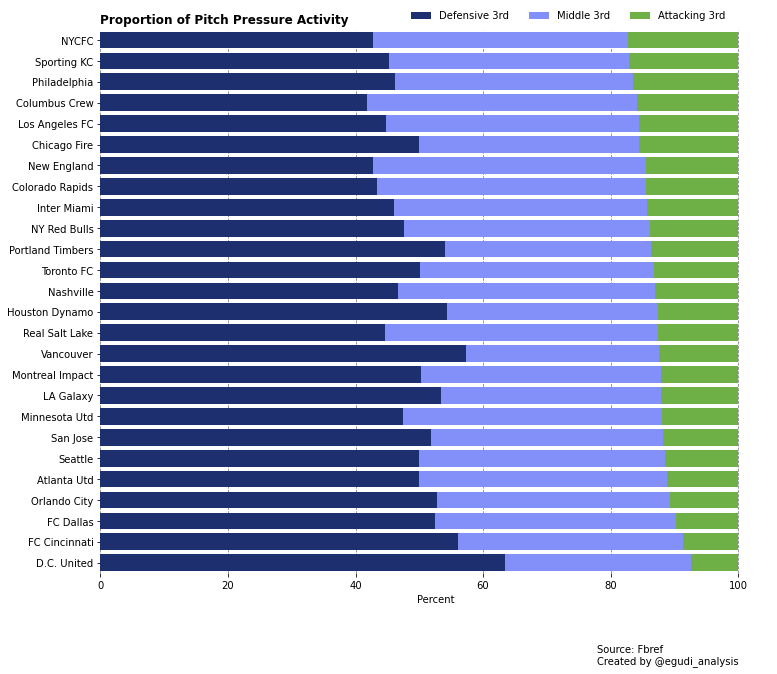

In [1626]:
pressing90['Sum'] = pressing90['Att 3rd']+pressing90['Mid 3rd']+pressing90['Def 3rd']
pressing90['Def3rdPer'] = (pressing90['Def 3rd'] / pressing90['Sum'])*100
pressing90['Mid3rdPer'] = (pressing90['Mid 3rd'] / pressing90['Sum'])*100
pressing90['Att3rdPer'] = (pressing90['Att 3rd'] / pressing90['Sum'])*100

pressing90 = pressing90.sort_values('Att3rdPer', ascending=True).reset_index()

fields = ['Def3rdPer','Mid3rdPer','Att3rdPer']
colors = ['#1D2F6F', '#8390FA', '#6EAF46']
labels = ['Defensive 3rd', 'Middle 3rd', 'Attacking 3rd']

# figure and axis
fig, ax = plt.subplots(1, figsize=(12, 10))

# plot bars
left = len(pressing90) * [0]
for idx, name in enumerate(fields):
    plt.barh(pressing90.Squad, pressing90[name], left = left, color=colors[idx])
    left = left + pressing90[name]
    
# title, legend, labels
plt.title('Proportion of Pitch Pressure Activity', loc='left', weight='bold')
plt.legend(labels, bbox_to_anchor=([0.45, 1, 0, 0]), ncol=4, frameon=False)
plt.xlabel('Percent')

# remove spines
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# adjust limits and draw grid lines
plt.ylim(-0.5, ax.get_yticks()[-1] + 0.5)
ax.set_axisbelow(True)
ax.xaxis.grid(color='gray', linestyle='dashed')

CREDIT_1 = 'Source: Fbref'
CREDIT_2 = 'Created by @egudi_analysis'
fig.text(0.7,-0.001, f'{CREDIT_1}\n{CREDIT_2}')

plt.savefig('prop-pressure.png')

Unsurprisingly, Philadelphia employs the third largest percentage of pressures in the attacking third, further illustrating the nature of their defensive structure.

# Passing Patterns

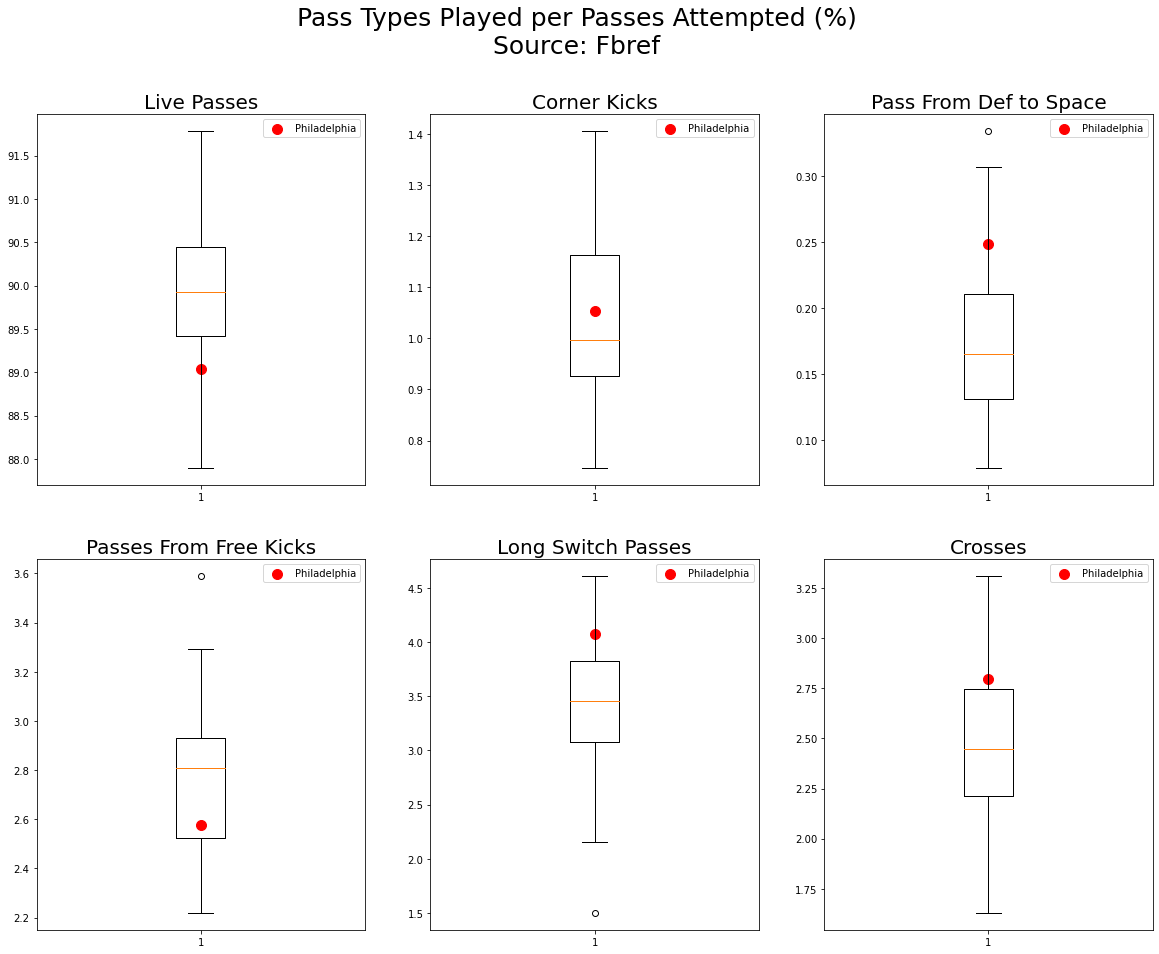

In [1631]:
pass_types = pd.read_csv('Data/pass-types-ninety.csv')

fig, ax = plt.subplots(nrows=2, ncols=3,
                       figsize=(20,15))

LivePassPer = (pass_types.Live / pass_types.Att)*100
FreeKickPer = (pass_types.FK / pass_types.Att)*100
CKPer = (pass_types.CK / pass_types.Att)*100
FortyYardWidePer = (pass_types.Sw / pass_types.Att)*100
CrossesPer = (pass_types.Crs / pass_types.Att)*100
TBPer = (pass_types.TB / pass_types.Att)*100
Data = [LivePassPer, FreeKickPer, CKPer, FortyYardWidePer, CrossesPer, TBPer]

ax[0,0].boxplot(Data[0:1]);
ax[0,0].set_title('Live Passes', fontsize=20)
ax[0,0].scatter(1, (404.3/454.1)*100, color='red', s=100, label='Philadelphia')
ax[0,0].legend()

ax[1,0].boxplot(Data[1:2]);
ax[1,0].set_title('Passes From Free Kicks', fontsize=20)
ax[1,0].scatter(1, (11.7/454.1)*100, color='red', s=100, label='Philadelphia')
ax[1,0].legend()

ax[0,1].boxplot(Data[2:3]);
ax[0,1].set_title('Corner Kicks', fontsize=20)
ax[0,1].scatter(1, (4.78/454.1)*100, color='red', s=100, label='Philadelphia')
ax[0,1].legend()

ax[1,1].boxplot(Data[3:4]);
ax[1,1].set_title('Long Switch Passes', fontsize=20)
ax[1,1].scatter(1, (18.5/454.1)*100, color='red', s=100, label='Philadelphia')
ax[1,1].legend()

ax[1,2].boxplot(Data[4:5]);
ax[1,2].set_title('Crosses', fontsize=20)
ax[1,2].scatter(1, (12.7/454.1)*100, color='red', s=100, label='Philadelphia')
ax[1,2].legend()

ax[0,2].boxplot(Data[5:]);
ax[0,2].set_title('Pass From Def to Space',fontsize=20);
ax[0,2].scatter(1, (1.13/454.1)*100, color='red', s=100, label='Philadelphia')
ax[0,2].legend()

plt.suptitle('Pass Types Played per Passes Attempted (%)\nSource: Fbref', fontsize=25);

plt.savefig('past-types-per.png')

When observing their passing patterns, Philadelphia plays a smaller portion of live passes than their peers. relative to the rest of the league, Philadelphia likes to have their back defenders play balls into space, while they also switch the ball long and cross more often as a share of their total passes.

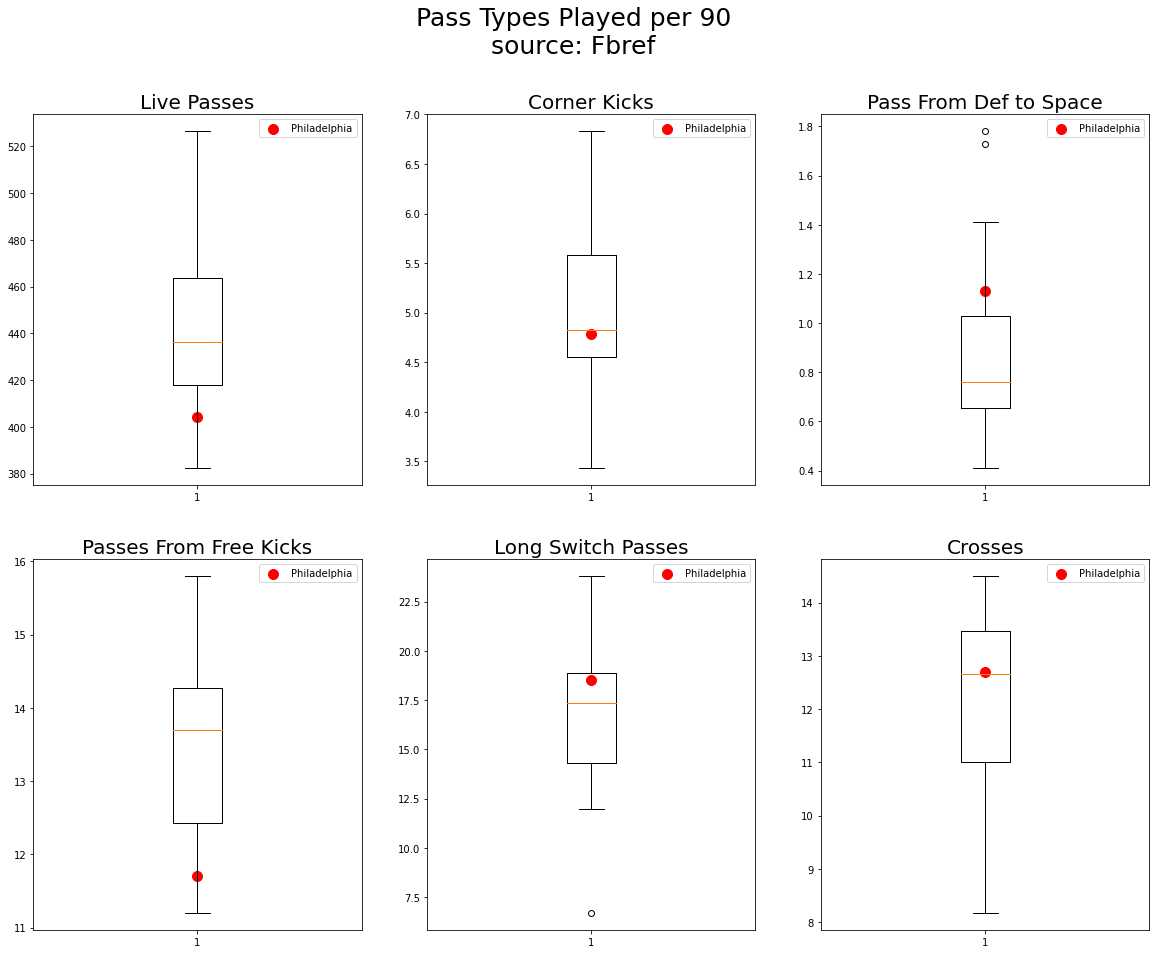

In [1632]:
fig, ax = plt.subplots(nrows=2, ncols=3,
                       figsize=(20,15))

LivePass = pass_types.Live
FreeKick = pass_types.FK 
CK = pass_types.CK 
FortyYardWide = pass_types.Sw
Crosses = pass_types.Crs 
TB = pass_types.TB
Data = [LivePass, FreeKick, CK, FortyYardWide, Crosses, TB]

ax[0,0].boxplot(Data[0:1]);
ax[0,0].set_title('Live Passes', fontsize=20)
ax[0,0].scatter(1, 404.3, color='red', s=100, label='Philadelphia')
ax[0,0].legend()

ax[1,0].boxplot(Data[1:2]);
ax[1,0].set_title('Passes From Free Kicks', fontsize=20)
ax[1,0].scatter(1, 11.7, color='red', s=100, label='Philadelphia')
ax[1,0].legend()

ax[0,1].boxplot(Data[2:3]);
ax[0,1].set_title('Corner Kicks', fontsize=20)
ax[0,1].scatter(1, 4.78, color='red', s=100, label='Philadelphia')
ax[0,1].legend()

ax[1,1].boxplot(Data[3:4]);
ax[1,1].set_title('Long Switch Passes', fontsize=20)
ax[1,1].scatter(1, 18.5, color='red', s=100, label='Philadelphia')
ax[1,1].legend()

ax[1,2].boxplot(Data[4:5]);
ax[1,2].set_title('Crosses', fontsize=20)
ax[1,2].scatter(1, 12.7, color='red', s=100, label='Philadelphia')
ax[1,2].legend()

ax[0,2].boxplot(Data[5:]);
ax[0,2].set_title('Pass From Def to Space',fontsize=20);
ax[0,2].scatter(1, 1.13, color='red', s=100, label='Philadelphia')
ax[0,2].legend()

plt.suptitle('Pass Types Played per 90\nsource: Fbref', fontsize=25);

plt.savefig('pass-types-per90.png')

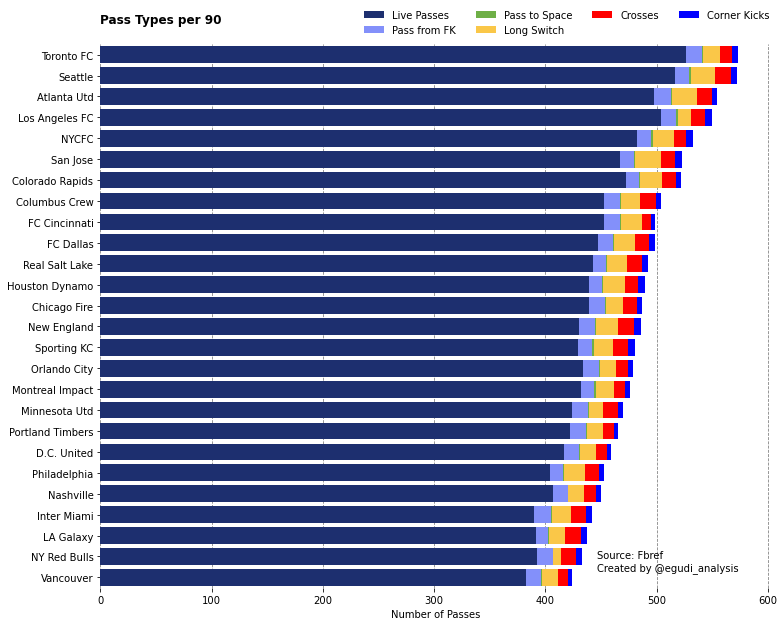

In [1633]:
fields = ['Live','FK','TB','Sw', 'Crs', 'CK']
colors = ['#1D2F6F', '#8390FA', '#6EAF46', '#FAC748', 'red', 'blue']
labels = ['Live Passes', 'Pass from FK', 'Pass to Space', 'Long Switch', 'Crosses', 'Corner Kicks']

pass_types['Sum'] = pass_types['Live']+pass_types['FK']+pass_types['CK']+pass_types['Sw']+pass_types['Crs']+pass_types['TB']

pass_types = pass_types.sort_values('Sum', ascending=True).reset_index()

# figure and axis
fig, ax = plt.subplots(1, figsize=(12, 10))

# plot bars
left = len(pass_types) * [0]
for idx, name in enumerate(fields):
    plt.barh(pass_types.Squad, pass_types[name], left = left, color=colors[idx])
    left = left + pass_types[name]
    
# title, legend, labels
plt.title('Pass Types per 90\n', loc='left', weight='bold')
plt.legend(labels, bbox_to_anchor=([0.38, 1, 0, 0]), ncol=4, frameon=False)
plt.xlabel('Number of Passes')

# remove spines
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# adjust limits and draw grid lines
plt.ylim(-0.5, ax.get_yticks()[-1] + 0.5)
ax.set_axisbelow(True)
ax.xaxis.grid(color='gray', linestyle='dashed')

CREDIT_1 = 'Source: Fbref'
CREDIT_2 = 'Created by @egudi_analysis'
fig.text(0.7,0.15, f'{CREDIT_1}\n{CREDIT_2}')

plt.savefig('pass-types-per-90.png')

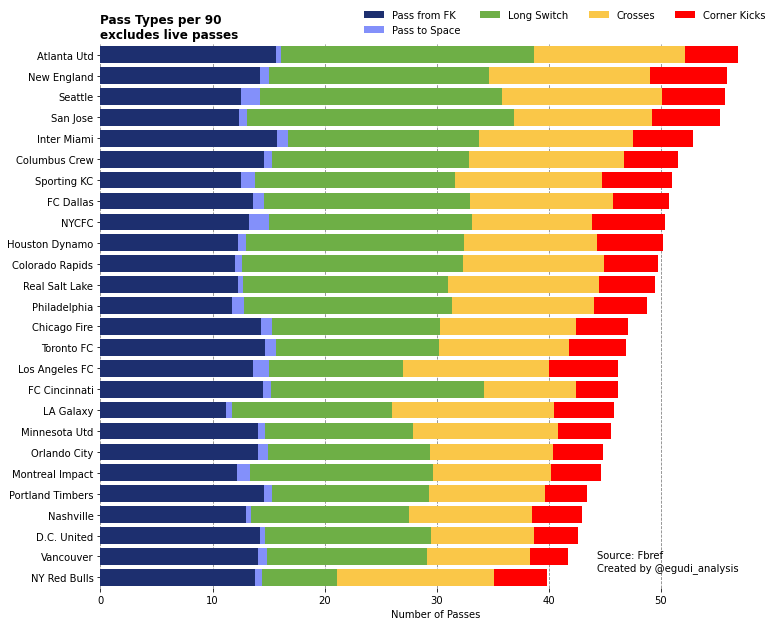

In [1634]:
fields = ['FK','TB','Sw', 'Crs', 'CK']
colors = ['#1D2F6F', '#8390FA', '#6EAF46', '#FAC748', 'red']
labels = ['Pass from FK', 'Pass to Space', 'Long Switch', 'Crosses', 'Corner Kicks']

pass_types['Sum'] = pass_types['FK']+pass_types['CK']+pass_types['Sw']+pass_types['Crs']+pass_types['TB']

pass_types = pass_types.sort_values('Sum', ascending=True).reset_index()

# figure and axis
fig, ax = plt.subplots(1, figsize=(12, 10))

# plot bars
left = len(pass_types) * [0]
for idx, name in enumerate(fields):
    plt.barh(pass_types.Squad, pass_types[name], left = left, color=colors[idx])
    left = left + pass_types[name]
    
# title, legend, labels
plt.title('Pass Types per 90\nexcludes live passes', loc='left', weight='bold')
plt.legend(labels, bbox_to_anchor=([0.38, 1, 0, 0]), ncol=4, frameon=False)
plt.xlabel('Number of Passes')

# remove spines
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# adjust limits and draw grid lines
plt.ylim(-0.5, ax.get_yticks()[-1] + 0.5)
ax.set_axisbelow(True)
ax.xaxis.grid(color='gray', linestyle='dashed')

CREDIT_1 = 'Source: Fbref'
CREDIT_2 = 'Created by @egudi_analysis'
fig.text(0.7,0.15, f'{CREDIT_1}\n{CREDIT_2}')

plt.savefig('pass-types-per-90-ex-live.png')

### Individual Player Stats

In [1404]:
player_pass = pd.read_csv('Data/mls-pl-pass.csv')
prog_pass = player_pass[['Player', '90s', 'Age', 'Squad', 'Pos', 'Cmp', 'Att', 'xA', 'KP', '1/3', 'Prog', 'PPA']]
player_poss = pd.read_csv('Data/mls-player-possession.csv')
prog_poss = player_poss[['Player', 'Prog', 'Mis', 'Dis']]

pl_df = pd.merge(prog_pass, prog_poss, on='Player', how='outer')
pl_df['Player'] = pl_df['Player'].str.split('\\', expand=True)
pl_df = pl_df[pl_df['90s'] > 10]
pl_df.head()

,Player,90s,Age,Squad,Pos,Cmp,Att,xA,KP,1/3,Prog_x,PPA,Prog_y,Mis,Dis
0,Brenden Aaronson,21.2,19,Philadelphia,MF,21.3,26.8,0.13,1.27,1.46,1.84,0.61,4.29,1.98,2.59
3,Lalas Abubakar,16.8,25,Colorado Rapids,DF,50.2,55.4,0.01,0.18,2.62,2.32,0.00,1.19,0.12,0.00
8,Kellyn Acosta,12.7,24,Colorado Rapids,MF,32.8,38.0,0.08,0.71,2.52,2.52,0.39,3.70,0.55,1.26
11,Ali Adnan Kadhim,19.6,26,Vancouver,DFMF,35.9,49.2,0.18,0.82,2.60,4.64,1.07,4.54,1.07,0.77
12,Harrison Afful,20.0,33,Columbus Crew,DF,54.1,68.3,0.07,0.80,4.75,6.55,1.50,4.10,0.80,0.70


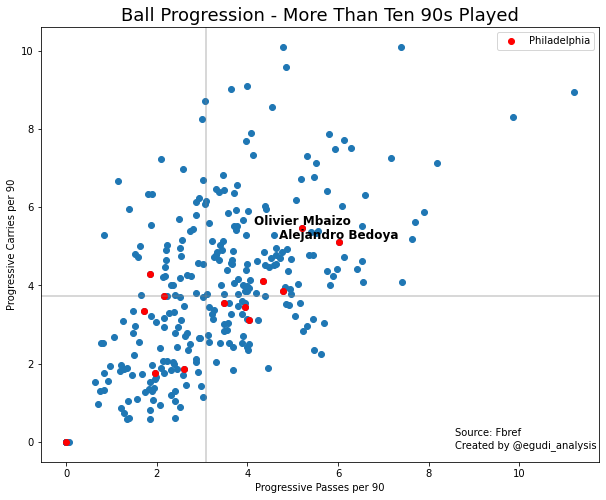

In [1635]:
fig, ax = plt.subplots(figsize=(10,8))
fig.set_facecolor('white')

philly = pl_df[pl_df['Squad'] == 'Philadelphia']

x = pl_df['Prog_x']
y = pl_df['Prog_y']

x2 = philly['Prog_x']
y2 = philly['Prog_y']

ax.scatter(x, y)
ax.scatter(x2, y2, color='red', label='Philadelphia')
ax.axvline(x=pl_df['Prog_x'].median(), color='gray', alpha=0.4)
ax.axhline(y=pl_df['Prog_y'].median(), color='gray', alpha=0.4)
ax.set_xlabel('Progressive Passes per 90', fontsize=10)
ax.set_ylabel('Progressive Carries per 90', fontsize=10)
ax.set_title('Ball Progression - More Than Ten 90s Played', fontsize=18)
ax.legend()

for index, row in philly.iterrows():  
    if row.Player == 'Olivier Mbaizo':
        ax.annotate(row.Player, xy=([row['Prog_x'], (row['Prog_y'])]), ha='center', va='bottom', 
                    color='black', fontsize=12, weight='bold') 
    elif row.Player == 'Alejandro Bedoya':
        ax.annotate(row.Player, xy=([row['Prog_x'], (row['Prog_y'])]), ha='center', va='bottom', 
                    color='black', fontsize=12, weight='bold') 
        
CREDIT_1 = 'Source: Fbref'
CREDIT_2 = 'Created by @egudi_analysis'
fig.text(0.7,0.15, f'{CREDIT_1}\n{CREDIT_2}')

plt.savefig('ball-progression-more-10.png')

Moving on to individual players, their most dangerous ball progressors are outside back, Olivier Mbaizo, and central midfielder, Alejandro Bedoya. Both put up decent output in terms of ball progression, well above the mean in both progressive carries per 90 and progressive passes per 90.

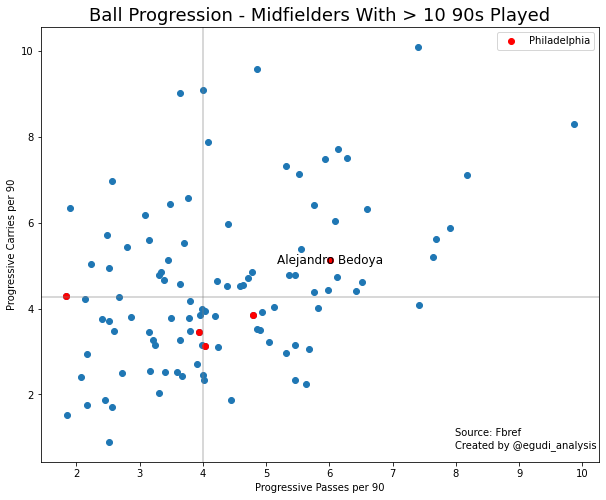

In [1636]:
['MF', 'DF', 'FWMF', 'MFFW', 'FW', 'DFMF', 'DFFW', 'MFDF', 'GK', 'FWDF']

fig, ax = plt.subplots(figsize=(10,8))
fig.set_facecolor('white')

mids = pl_df[pl_df['Pos'].isin(['MF', 'MFFW', 'DFMF', 'MFDF'])]
mids_p = philly[philly['Pos'].isin(['MF', 'MFFW', 'DFMF', 'MFDF'])]

x = mids['Prog_x']
y = mids['Prog_y']

x2 = mids_p['Prog_x']
y2 = mids_p['Prog_y']

ax.scatter(x, y)
ax.scatter(x2, y2, color='red', label='Philadelphia')
ax.axvline(x=mids['Prog_x'].median(), color='gray', alpha=0.4)
ax.axhline(y=mids['Prog_y'].median(), color='gray', alpha=0.4)
ax.set_xlabel('Progressive Passes per 90', fontsize=10)
ax.set_ylabel('Progressive Carries per 90', fontsize=10)
ax.set_title('Ball Progression - Midfielders With > 10 90s Played', fontsize=18)
ax.legend()

for index, row in mids_p.iterrows():
    if row.Prog_x > 5:
        ax.annotate(row.Player, xy=([row.Prog_x, row.Prog_y]), fontsize=12, ha='center', va='center')
        
CREDIT_1 = 'Source: Fbref'
CREDIT_2 = 'Created by @egudi_analysis'
fig.text(0.7,0.15, f'{CREDIT_1}\n{CREDIT_2}')

plt.savefig('ball-prog-mids.png')

Among midfielders, Bedoya stands out somewhat again as Philadelphia's most dangerous midfielder, though still lags a decent portion of the league in both metrics.

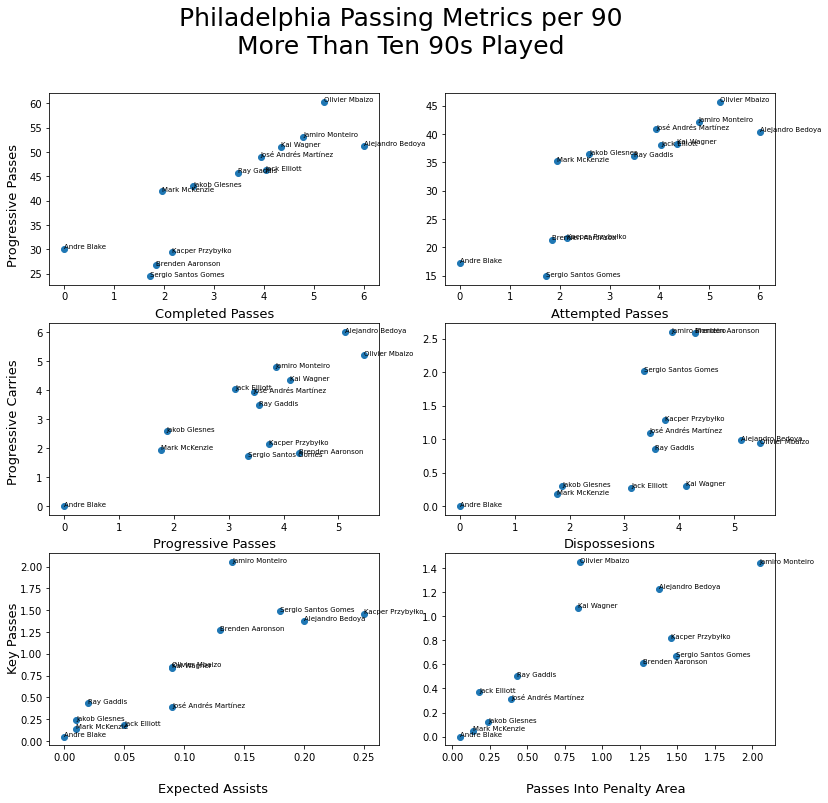

In [1637]:
fig, ax = plt.subplots(nrows=3, ncols=2, 
                       figsize=(13,12),
                       squeeze=False)

ax[0,0].scatter(philly.Prog_x, philly.Att);
for index, row in philly.iterrows():
    ax[0,0].annotate(row.Player, xy=(row.Prog_x, row.Att), fontsize=7)

ax[0,1].scatter(philly.Prog_x, philly.Cmp);
for index, row in philly.iterrows():
    ax[0,1].annotate(row.Player, xy=(row.Prog_x, row.Cmp), fontsize=7)

ax[1,0].scatter(philly.Prog_y, philly.Prog_x);
ax[1,0].set_title('Completed Passes',fontsize=13);
for index, row in philly.iterrows():
    ax[1,0].annotate(row.Player, xy=(row.Prog_y, row.Prog_x), fontsize=7)

ax[1,1].scatter(philly.Prog_y, philly.Dis);
ax[1,1].set_title('Attempted Passes', fontsize=13)
for index, row in philly.iterrows():
    ax[1,1].annotate(row.Player, xy=(row.Prog_y, row.Dis),fontsize=7)

ax[2,0].scatter(philly.xA, philly.KP)
ax[2,0].set_title('Progressive Passes', fontsize=13)
for index, row in philly.iterrows():
    ax[2,0].annotate(row.Player, xy=(row.xA, row.KP),fontsize=7)

ax[2,1].scatter(philly.KP, philly.PPA);
ax[2,1].set_title('Dispossesions', fontsize=13)
for index, row in philly.iterrows():
    ax[2,1].annotate(row.Player, xy=(row.KP, row.PPA), fontsize=7)


fig.text(0.3, 0.07, 'Expected Assists', ha='center', fontsize=13)
fig.text(0.72, 0.07, 'Passes Into Penalty Area', ha='center', fontsize=13)

fig.text(0.08, 0.75, 'Progressive Passes', va='center', rotation='vertical', fontsize=13)
fig.text(0.08, 0.5, 'Progressive Carries', va='center', rotation='vertical', fontsize=13)
fig.text(0.08, 0.25, 'Key Passes', va='center', rotation='vertical', fontsize=13)

plt.suptitle('Philadelphia Passing Metrics per 90\nMore Than Ten 90s Played', fontsize=25);

plt.savefig('pass-metrics-per90.png')

Again, Bedoya stands out as one of Philadelphia's elite ball progressive passers, while also completing and attempting the most passes within the team, highlighting his role in both progressing the ball in the attack and in possession. As mentioned earlier, Mbaizo is the team's most prolific progressive passer but also is involved in possession almost as much as Bedoya.

Again, Bedoya and Mbaizo stand out as they limit dispossesions to about one a game, despite their tendency to play forward most often. Left back, Kai Wagner, also stands out in terms of carrying the ball forward down the wing and limiting dispossesions, while Jamiro Montero and Paxten Aaronson progress the ball forward through carries quite often; though they tend to lose the ball a lot a lot relative to their teammates.

Monteiro, leads the team in key passes per 90 while Bedoya and Przybylko are also heavily involved in chance creation given their expected assists values between 0.20 and 0.25. Monteiro also tends to play passes into the penalty area more often, leading the next three players by almost more than half a pass per 90. 

In [1409]:
def_pl = pd.read_csv('Data/player-pressures.csv')
def_pl['Player'] = def_pl['Player'].str.split('\\', expand=True)
philly_d = def_pl[['Player', 'Pos', '90s', 'Squad', 'Tkl', 'TklW', 'Press', 'Succ', 'Att 3rd', 'Def 3rd.1', 'Mid 3rd.1', 'Att 3rd.1', 'Int', 'Tkl+Int']]
philly_d = philly_d[philly_d['90s'] > 10]
philly_d = philly_d[philly_d['Squad'] == 'Philadelphia']

In [1410]:
philly_d

,Player,Pos,90s,Squad,Tkl,TklW,Press,Succ,Att 3rd,Def 3rd.1,Mid 3rd.1,Att 3rd.1,Int,Tkl+Int
0,Brenden Aaronson,MF,21.2,Philadelphia,2.26,1.42,26.50,6.84,0.61,5.66,12.60,8.16,0.42,2.69
30,José Andrés Martínez,MF,12.7,Philadelphia,3.15,2.60,21.80,6.54,0.08,10.20,10.50,1.18,0.94,4.09
60,Alejandro Bedoya,MF,20.3,Philadelphia,2.17,1.23,13.00,4.14,0.54,4.33,5.57,3.10,0.94,3.10
76,Andre Blake,GK,21.0,Philadelphia,0.05,0.05,0.24,0.05,0.00,0.24,0.00,0.00,0.00,0.05
182,Jack Elliott,DFMF,10.9,Philadelphia,2.94,1.65,15.20,5.14,0.09,7.52,6.88,0.83,0.18,3.12
215,Ray Gaddis,DF,14.1,Philadelphia,1.99,0.71,16.80,5.04,0.21,9.43,5.46,1.91,0.92,2.91
229,Jakob Glesnes,DF,16.6,Philadelphia,1.45,0.72,8.61,3.37,0.06,4.70,3.43,0.48,1.02,2.47
371,Olivier Mbaizo,DF,11.7,Philadelphia,2.65,1.79,14.60,3.76,0.43,6.41,5.56,2.65,1.45,4.10
375,Mark McKenzie,DF,22.0,Philadelphia,2.05,1.41,10.60,3.50,0.00,6.68,3.59,0.36,0.82,2.86
407,Jamiro Monteiro,MF,21.5,Philadelphia,2.60,1.86,20.90,6.05,0.60,5.49,11.70,3.77,1.02,3.63


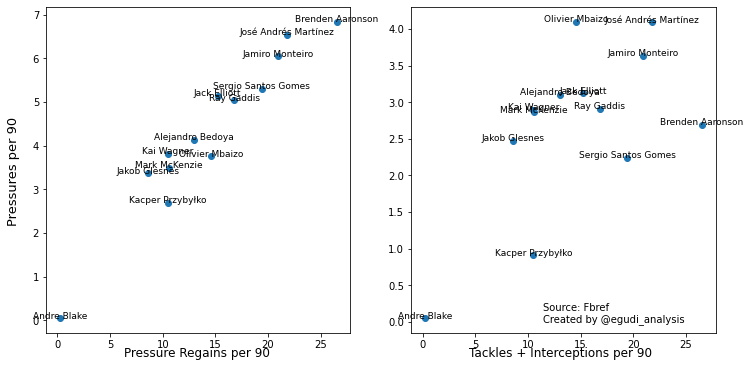

In [1638]:
fig, ax = plt.subplots(nrows=1, ncols=2, 
                       figsize=(12,6),
                       squeeze=False)

ax[0,0].scatter(philly_d.Press, philly_d.Succ);
for index, row in philly_d.iterrows():
    ax[0,0].annotate(row.Player, xy=(row.Press, row.Succ), fontsize=9, ha='center')

ax[0,1].scatter(philly_d.Press, philly_d['Tkl+Int']);
for index, row in philly_d.iterrows():
    ax[0,1].annotate(row.Player, xy=(row.Press, row['Tkl+Int']), fontsize=9, ha='center')
    
fig.text(0.3, 0.07, 'Pressure Regains per 90', ha='center', fontsize=12)
fig.text(0.72, 0.07, 'Tackles + Interceptions per 90', ha='center', fontsize=12);

fig.text(0.08, 0.5, 'Pressures per 90', va='center', rotation='vertical', fontsize=13);

CREDIT_1 = 'Source: Fbref'
CREDIT_2 = 'Created by @egudi_analysis'
fig.text(0.7,0.15, f'{CREDIT_1}\n{CREDIT_2}')

plt.savefig('indi-def-90')

Looking at pressing activity, pressures and pressure regains are mostly concentrated within attacking players such as Aaronson anf Martinez. Another player that stands out is Jose Martinez as he ranks highly among the team in pressures, pressure regains, and defensive actions, thus highlighting the importance of his role within the team's pressing structure.

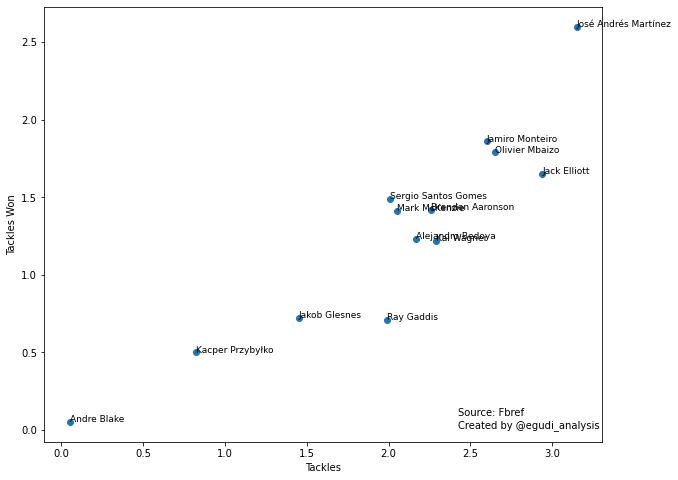

In [1639]:
fig, ax = plt.subplots(figsize=(10,8))

ax.scatter(philly_d.Tkl, philly_d.TklW);
for index, row in philly_d.iterrows():
    ax.annotate(row.Player, xy=(row.Tkl, row.TklW), fontsize=9)

ax.set_xlabel('Tackles')
ax.set_ylabel('Tackles Won')

CREDIT_1 = 'Source: Fbref'
CREDIT_2 = 'Created by @egudi_analysis'
fig.text(0.7,0.15, f'{CREDIT_1}\n{CREDIT_2}')

plt.savefig('tackles.png')

Not only is Martinez heavily involved in the pressing activity but he also wins and attempts the most tackles per 90.

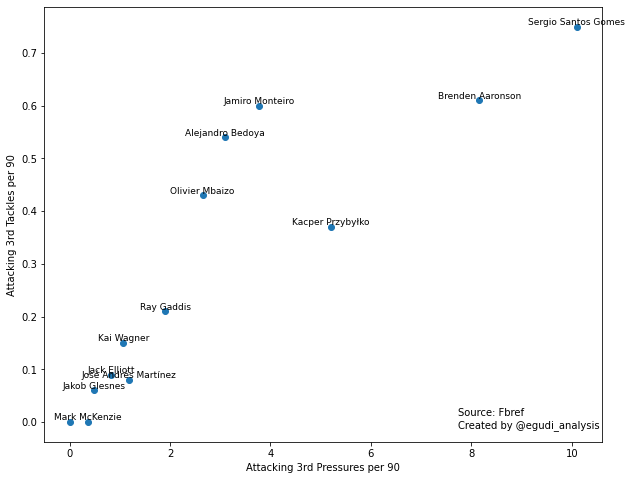

In [1640]:
fig, ax = plt.subplots(figsize=(10,8))

ax.scatter(philly_d['Att 3rd.1'], philly_d['Att 3rd']);
for index, row in philly_d.iterrows(): 
    if row['Att 3rd.1'] > 0:
        ax.annotate(row.Player, xy=(row['Att 3rd.1'], row['Att 3rd']), fontsize=9, ha='center', va='bottom')

ax.set_xlabel('Attacking 3rd Pressures per 90')
ax.set_ylabel('Attacking 3rd Tackles per 90');

CREDIT_1 = 'Source: Fbref'
CREDIT_2 = 'Created by @egudi_analysis'
fig.text(0.7,0.15, f'{CREDIT_1}\n{CREDIT_2}')

plt.savefig('att-p.png')

In the attacking third, the most active player in the pressing face has been the forward, Sergio Gomez, recording the highest number of tackles and pressures in the attacking third.

### 3. Set-piece report for next match vs. Philadelphia Union What are some statistical trends for the opponent’s set piece behavior?

In [1643]:
pass_types['CK'] = round(pass_types['CK'], 0).astype('int')
ck = pass_types[['Squad', 'CK']]

pass_types_a = pd.read_csv('Data/pass_types_a.csv')
cka = pass_types_a[['Squad', 'CK']]

cks = pd.merge(ck, cka, on='Squad', how='outer')

mls_misc['Squad'] = mls_misc['Squad'].str.replace('CF Montréal', 'Montreal Impact')
aerials = mls_misc[['Squad', 'Won', 'Won%']]
aerials['Won'] = aerials['Won'] / 90
cks = pd.merge(cks, aerials, on='Squad', how='outer')

xG = mls_table[['Squad','xG', 'xGA']]
xG['Squad'] = xG['Squad'].str.replace('CF Montréal', 'Montreal Impact')

corners = pd.merge(xG, cks, on='Squad', how='outer')
corners['xGperCK'] = corners['xG'] / corners['CK_x']
corners['xGAperCKA'] = corners['xGA'] / corners['CK_y']
corners = corners.dropna(axis=0)

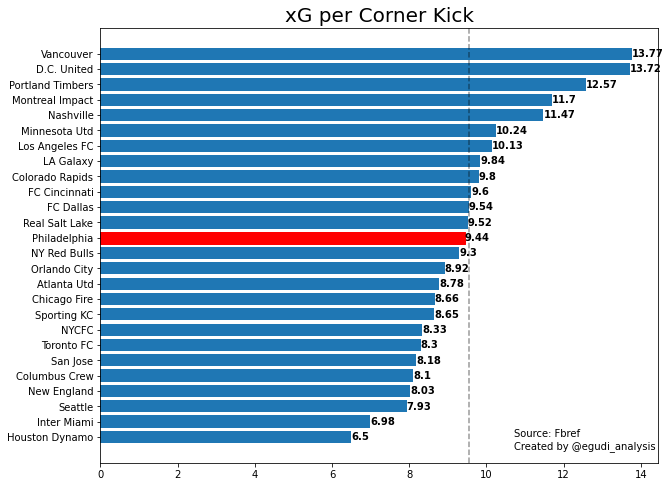

In [1644]:
corners = corners.sort_values('xGperCK', ascending=True).reset_index()

fig, ax = plt.subplots(figsize=(10, 8))

y = corners.xGperCK
x = corners.Squad

ax.barh(x, y)
ax.get_children()[13].set_color('red')
ax.set_title('xG per Corner Kick', fontsize=20)
ax.axvline(x=corners.xGperCK.mean(), linestyle='--', color='black', alpha=0.4)

for index, row in corners.iterrows():
    ax.annotate(round(row.xGperCK,2), xy=(row.xGperCK, row.Squad), va='center', weight='bold')
    
CREDIT_1 = 'Source: Fbref'
CREDIT_2 = 'Created by @egudi_analysis'
fig.text(0.7,0.15, f'{CREDIT_1}\n{CREDIT_2}')

plt.savefig('xG-corner.png')

Looking at Philadelphia's trends from corner kicks, Philadelphia has been converting 9.44 expected goals per corner kick taken, which is right about the average conversion rate in the league.

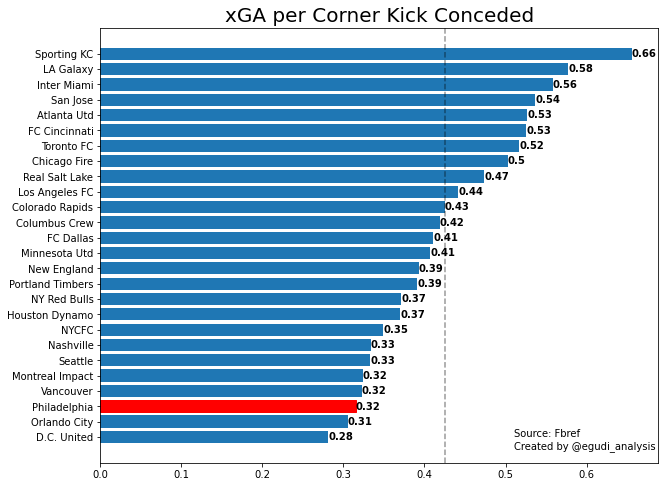

In [1645]:
corners = corners.sort_values('xGAperCKA', ascending=True).reset_index()

fig, ax = plt.subplots(figsize=(10, 8))

y = corners.xGAperCKA
x = corners.Squad

ax.barh(x, y)
ax.get_children()[2].set_color('red')
ax.set_title('xGA per Corner Kick Conceded', fontsize=20)
ax.axvline(x=corners.xGAperCKA.mean(), linestyle='--', color='black', alpha=0.4)

for index, row in corners.iterrows():
    ax.annotate(round(row.xGAperCKA,2), xy=(row.xGAperCKA, row.Squad), va='center', weight='bold')
    
CREDIT_1 = 'Source: Fbref'
CREDIT_2 = 'Created by @egudi_analysis'
fig.text(0.7,0.15, f'{CREDIT_1}\n{CREDIT_2}')

plt.savefig('xGa-corner.png')

However, defensively they look excelent as they are conceding the third lowest expected goals per corner kick conceded in the league, highlighting their defensive solidity when it comes to set pieces.

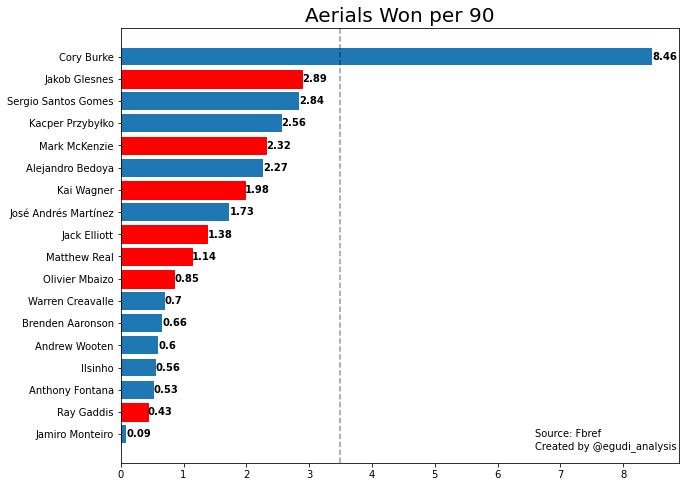

In [1646]:
aerials_p = pd.read_csv('Data/aerials_philly.csv')
aerials_p['Player'] = aerials_p['Player'].str.split('\\', expand=True)
aerials_p = aerials_p.sort_values('Won', ascending=True).reset_index()
aerials_p = aerials_p.dropna(axis=0).reset_index()

fig, ax = plt.subplots(figsize=(10, 8))

y = aerials_p.Won
x = aerials_p.Player

ax.barh(x, y)
ax.get_children()[1].set_color('red')
ax.get_children()[7].set_color('red')
ax.get_children()[8].set_color('red')
ax.get_children()[9].set_color('red')
ax.get_children()[9].set_color('red')
ax.get_children()[11].set_color('red')
ax.get_children()[13].set_color('red')
ax.get_children()[16].set_color('red')

ax.set_title('Aerials Won per 90', fontsize=20)
ax.axvline(x=corners.Won.mean(), linestyle='--', color='black', alpha=0.4)

for index, row in aerials_p.iterrows():
    ax.annotate(row.Won, xy=(row.Won, row.Player), va='center', weight='bold')

CREDIT_1 = 'Source: Fbref'
CREDIT_2 = 'Created by @egudi_analysis'
fig.text(0.7,0.15, f'{CREDIT_1}\n{CREDIT_2}')

plt.savefig('aerials90.png')

In order to point out any potential players to target, when taking offensive set pieces, we looked at Aerials won overall. Red bars represent defensive players. Forward, Cory Burke has won almost four times as much as the next highest, although he may rarely be found in the box defending corners. Interestingly enough, only one defender stands out in the top four of aerials won per 90.

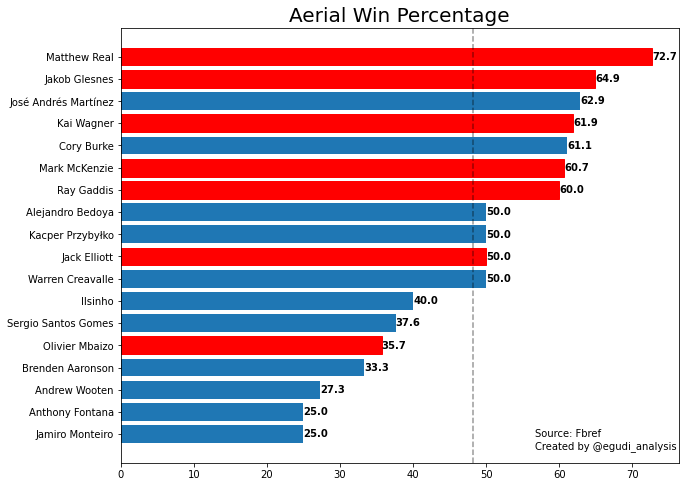

In [1647]:
aerials_p = pd.read_csv('Data/aerials_philly.csv')
aerials_p['Player'] = aerials_p['Player'].str.split('\\', expand=True)
aerials_p = aerials_p.sort_values('Won%', ascending=True).reset_index()
aerials_p = aerials_p.dropna(axis=0).reset_index()

fig, ax = plt.subplots(figsize=(10, 8))

y = aerials_p['Won%']
x = aerials_p.Player

ax.barh(x, y)
ax.get_children()[4].set_color('red')
ax.get_children()[8].set_color('red')
ax.get_children()[11].set_color('red')
ax.get_children()[12].set_color('red')
ax.get_children()[14].set_color('red')
ax.get_children()[16].set_color('red')
ax.get_children()[17].set_color('red')

ax.set_title('Aerial Win Percentage', fontsize=20)
ax.axvline(x=aerials_p['Won%'].mean(), linestyle='--', color='black', alpha=0.4)

for index, row in aerials_p.iterrows():
    ax.annotate(row['Won%'], xy=(row['Won%'], row.Player), va='center', weight='bold')
    
CREDIT_1 = 'Source: Fbref'
CREDIT_2 = 'Created by @egudi_analysis'
fig.text(0.7,0.15, f'{CREDIT_1}\n{CREDIT_2}')

plt.savefig('aerials-win-per.png')

However, when looking at aerial win percentage, three out of the top five are defenders, while Burke falls down to fifth. Center back, Jack Elliot, seems like a potential player to target, given he only wins 50% of aerials and is probable to be involved in defending corners due to his defensive duties. Mbaizo could also be a target but unlikely given his minimal role within corner kicks as a wide player.

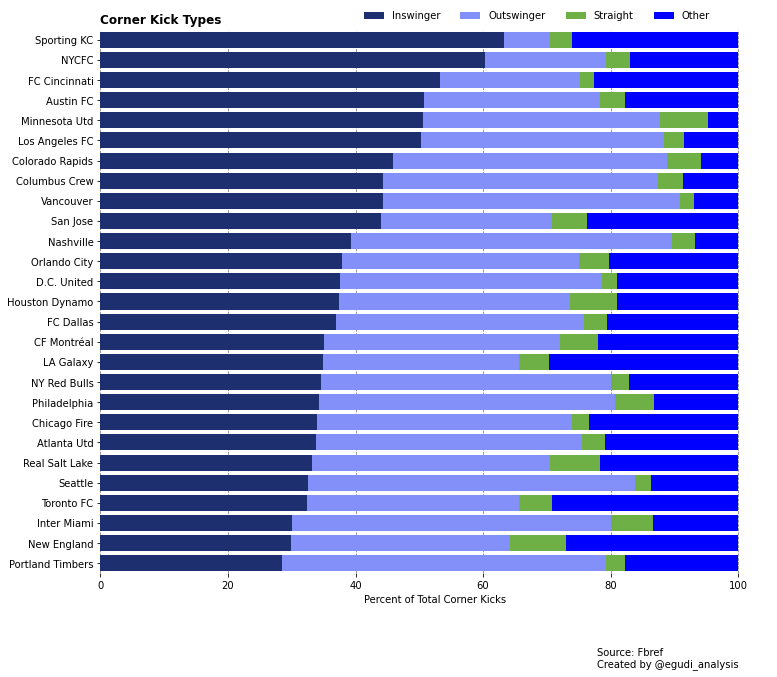

In [1648]:
pass_type = pd.read_csv('Data/pass-type.csv')

pass_type['OtherCK'] = pass_type['CK'] - (pass_type['In']+pass_type['Out']+pass_type['Str'])
pass_type['InPer'] = (pass_type['In'] /pass_type['CK'])*100
pass_type['OutPer'] = (pass_type['Out'] /pass_type['CK'])*100
pass_type['StrPer'] = (pass_type['Str'] /pass_type['CK'])*100
pass_type['OtherPer'] = (pass_type['OtherCK'] /pass_type['CK'])*100

pass_type = pass_type.sort_values('InPer', ascending=True)

fields = ['InPer','OutPer','StrPer', 'OtherPer']
colors = ['#1D2F6F', '#8390FA', '#6EAF46', 'blue']
labels = ['Inswinger', 'Outswinger', 'Straight', 'Other']

# figure and axis
fig, ax = plt.subplots(1, figsize=(12, 10))

# plot bars
left = len(pass_type) * [0]
for idx, name in enumerate(fields):
    plt.barh(pass_type.Squad, pass_type[name], left = left, color=colors[idx])
    left = left + pass_type[name]
    
# title, legend, labels
plt.title('Corner Kick Types', loc='left', weight='bold')
plt.legend(labels, bbox_to_anchor=([0.38, 1, 0, 0]), ncol=4, frameon=False)
plt.xlabel('Percent of Total Corner Kicks')

# remove spines
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# adjust limits and draw grid lines
plt.ylim(-0.5, ax.get_yticks()[-1] + 0.5)
ax.set_axisbelow(True)
ax.xaxis.grid(color='gray', linestyle='dashed')

CREDIT_1 = 'Source: Fbref'
CREDIT_2 = 'Created by @egudi_analysis'
fig.text(0.7,-0.005, f'{CREDIT_1}\n{CREDIT_2}')

plt.savefig('corner-kick-types.png')

Now examining corner kick type trends for Philadelphia relative to the rest of the league, Philadelphia prefers playing outswingers over inswingers.

# Exercise 2 
Fast forward to the 2022 MLS season, and the opening of the summer transfer window – Nashville SC is looking to bring in a reinforcement on the flanks. With a fluid system between 5-3-2 and 4-2-3-1, the team is looking for a versatile player that can play a variety of positions on the right and/or left side. The General Manager has asked you for the following:

1. Identify a shortlist of 5 players in MLS that fit the requested profile: a versatile winger with attacking and defending 1v1 abilities, effective crossing in open play and set pieces, and consistent fitness levels.

2. What are the key data points that suggest each player fits the profile? Where do they rank relative to other players?

3. What are the gaps in the player’s abilities/behaviors that need consideration? How confident are you in your analysis?

4. What are other considerations in the player’s profile? How will they fit in the current Nashville SC squad?

In [1740]:
pt = pd.read_csv('Data/playing-time.csv')
pt = pt[['Player', 'Squad', 'Pos', 'Age', '90s', 'Mn/Start', 'PPM']]
pt['Player'] = pt['Player'].str.split('\\', expand=True)

pl_pass_types = pd.read_csv('Data/player-pass-types.csv')
pl_pass_types['Player'] = pl_pass_types['Player'].str.split('\\', expand=True)
pl_pass_types = pl_pass_types[['Player', 'Dead']]

player_pass = player_pass[['Player', 'CrsPA', 'xA', 'KP']]
player_pass['Player'] = player_pass['Player'].str.split('\\', expand=True)
player_poss = player_poss[['Player', 'Succ%', 'Prog']]
player_poss['Player'] = player_poss['Player'].str.split('\\', expand=True)

pl_def = def_pl[['Player', 'Tkl+Int', 'Tkl%']]

dfs = [pt, pl_pass_types, player_pass, player_poss, pl_def]

df_merged = reduce(lambda left,right: pd.merge(left,right,on=['Player'],
                                               how='outer'), dfs).reset_index()
df = df_merged
df = df.drop('PPM', axis=1)

In [1746]:
twumasi = df_merged[df_merged['Player'] == 'Ema Twumasi']
twumasi.dtypes

index         int64
Player       object
Squad        object
Pos          object
Age         float64
90s         float64
Mn/Start    float64
PPM         float64
Dead        float64
CrsPA       float64
xA          float64
KP          float64
Succ%       float64
Prog        float64
Tkl+Int     float64
Tkl%        float64
dtype: object

In [1733]:
martins = df_merged[df_merged['Player'] == 'Luís Martins']
martins

,index,Player,Squad,Pos,Age,90s,Mn/Start,PPM,Dead,CrsPA,xA,KP,Succ%,Prog,Tkl+Int,Tkl%
514,514,Luís Martins,Sporting KC,DF,28.0,32.8,88.0,1.69,10.8,0.58,0.1,1.4,70.0,7.09,2.56,47.1


In [1735]:
valenzuela = df_merged[df_merged['Player'] == 'Milton Valenzuela']
valenzuela

,index,Player,Squad,Pos,Age,90s,Mn/Start,PPM,Dead,CrsPA,xA,KP,Succ%,Prog,Tkl+Int,Tkl%
836,836,Milton Valenzuela,Columbus Crew,DF,22.0,9.7,70.0,1.43,7.63,0.43,0.11,0.87,54.5,6.77,2.36,30.0


In [1752]:
t = df_merged[df_merged['Player'] == 'Ema Twumasi']
t = t.fillna(value=0)

In [1744]:
dfp = df[df['Player'].isin(['Alex Roldan', 'Milton Valenzuela', 'Luís Martins', 'Ema Twumasi', 'Adam Lundqvist'])]
dfp.to_csv('mls-player-list.csv')

In [1751]:
# create params to map
params = list(df.columns)
params = params[6:]

# filter for player to analyze
player = df.loc[df['Player'] == 'Ema Twumasi'].reset_index()
df = df.loc[df['Pos'].isin(['DF'])]
player = list(player.loc[0])
player = player[7:]

# create list of values to plot and convert to percentiles
values = []
for x in range(len(params)):
    values.append(math.floor(stats.percentileofscore(df[params[x]], player[x])))
    
# load some fonts
font_normal = FontManager(("https://github.com/google/fonts/blob/main/apache/roboto/static/"
                           "Roboto-Regular.ttf?raw=true"))
font_italic = FontManager(("https://github.com/google/fonts/blob/main/apache/roboto/static/"
                           "Roboto-Italic.ttf?raw=true"))
font_bold = FontManager(("https://github.com/google/fonts/blob/main/apache/roboto/static/"
                         "Roboto-Medium.ttf?raw=true"))

# color of slices and text
slice_colors = ['#1A78CF'] * 9
text_color = ["#000000"] * 9 

# instantiate PyPizza class
baker = PyPizza(
    params=params,
    background_color='#222222',
    straight_line_color='#000000',
    straight_line_lw=1,
    last_circle_color='#000000',
    last_circle_lw=1,
    other_circle_lw=1,
    inner_circle_size=10
)

# plot pizza
fig, ax = baker.make_pizza(
    values,
    figsize=(8, 8.5),
    color_blank_space='same',
    slice_colors=slice_colors,
    value_colors=text_color,
    value_bck_colors=slice_colors,
    blank_alpha=0.4,
    kwargs_values=dict(
        color='#F2F2F', fontsize=11,
        fontproperties=font_normal.prop, zorder=3,
        bbox=dict(
            edgecolor='#000000', facecolor='conrflowerblue',
            boxstyle='round,pad=0.2', lw=1
        )
    ),
    kwargs_slices=dict(
        edgecolor='#000000', zorder=2, linewidth=1
    ),
    kwargs_params=dict(
        color='#F2F2F2', fontsize=11,
        fontproperties=font_normal.prop, va='center'
    )
)

# add title
fig.text(
    0.515, 0.975, 'Ema Twumasi - FC Dallas - Defender', size=18,
    fontproperties=font_bold.prop, color='#F2F2F2',
    ha='center')

# add subtitle
fig.text(
    0.515, 0.95, 
    'Per 90 Percentile Rank vs Defenders in the MLS* | Season 2021',
    size=15, fontproperties=font_bold.prop, color='#F2F2F2',
    ha='center'
)

# add credits
CREDIT_1 = 'data: statsbomb via fbref'

fig.text(
    0.99, 0.02, f'{CREDIT_1}', size=9,
    ha='right', color='#F2F2F2'
)


# add text
fig.text(
    0.02, 0.02, '*Excludes players with less than 10 90s played', color='#F2F2F2')

plt.savefig('Twumasi.png')

ValueError: cannot convert float NaN to integer

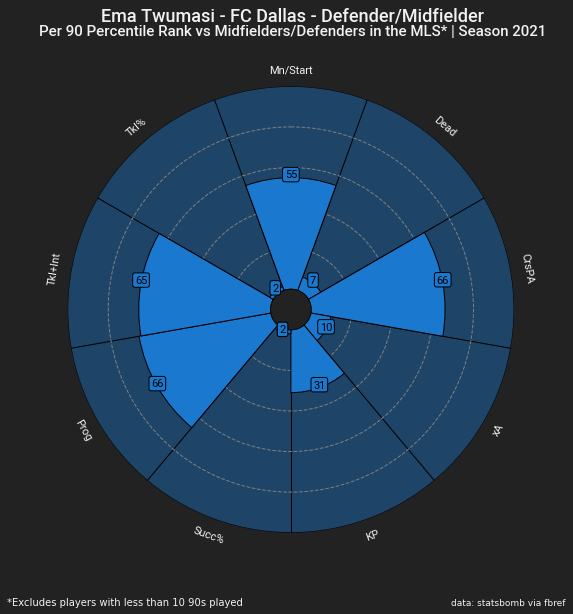

In [1753]:
# create params to map
params = list(df.columns)
params = params[6:]

# filter for player to analyze
player = t.loc[t['Player'] == 'Ema Twumasi'].reset_index()
player = list(player.loc[0])
player = player[7:]

# create list of values to plot and convert to percentiles
values = []
for x in range(len(params)):
    values.append(math.floor(stats.percentileofscore(df[params[x]], player[x])))
    
# load some fonts
font_normal = FontManager(("https://github.com/google/fonts/blob/main/apache/roboto/static/"
                           "Roboto-Regular.ttf?raw=true"))
font_italic = FontManager(("https://github.com/google/fonts/blob/main/apache/roboto/static/"
                           "Roboto-Italic.ttf?raw=true"))
font_bold = FontManager(("https://github.com/google/fonts/blob/main/apache/roboto/static/"
                         "Roboto-Medium.ttf?raw=true"))

# color of slices and text
slice_colors = ['#1A78CF'] * 9
text_color = ["#000000"] * 9 

# instantiate PyPizza class
baker = PyPizza(
    params=params,
    background_color='#222222',
    straight_line_color='#000000',
    straight_line_lw=1,
    last_circle_color='#000000',
    last_circle_lw=1,
    other_circle_lw=1,
    inner_circle_size=10
)

# plot pizza
fig, ax = baker.make_pizza(
    values,
    figsize=(8, 8.5),
    color_blank_space='same',
    slice_colors=slice_colors,
    value_colors=text_color,
    value_bck_colors=slice_colors,
    blank_alpha=0.4,
    kwargs_values=dict(
        color='#F2F2F', fontsize=11,
        fontproperties=font_normal.prop, zorder=3,
        bbox=dict(
            edgecolor='#000000', facecolor='conrflowerblue',
            boxstyle='round,pad=0.2', lw=1
        )
    ),
    kwargs_slices=dict(
        edgecolor='#000000', zorder=2, linewidth=1
    ),
    kwargs_params=dict(
        color='#F2F2F2', fontsize=11,
        fontproperties=font_normal.prop, va='center'
    )
)

# add title
fig.text(
    0.515, 0.975, 'Ema Twumasi - FC Dallas - Defender/Midfielder', size=18,
    fontproperties=font_bold.prop, color='#F2F2F2',
    ha='center')

# add subtitle
fig.text(
    0.515, 0.95, 
    'Per 90 Percentile Rank vs Midfielders/Defenders in the MLS* | Season 2021',
    size=15, fontproperties=font_bold.prop, color='#F2F2F2',
    ha='center'
)

# add credits
CREDIT_1 = 'data: statsbomb via fbref'

fig.text(
    0.99, 0.02, f'{CREDIT_1}', size=9,
    ha='right', color='#F2F2F2'
)


# add text
fig.text(
    0.02, 0.02, '*Excludes players with less than 10 90s played', color='#F2F2F2')

plt.savefig('raheem.png')

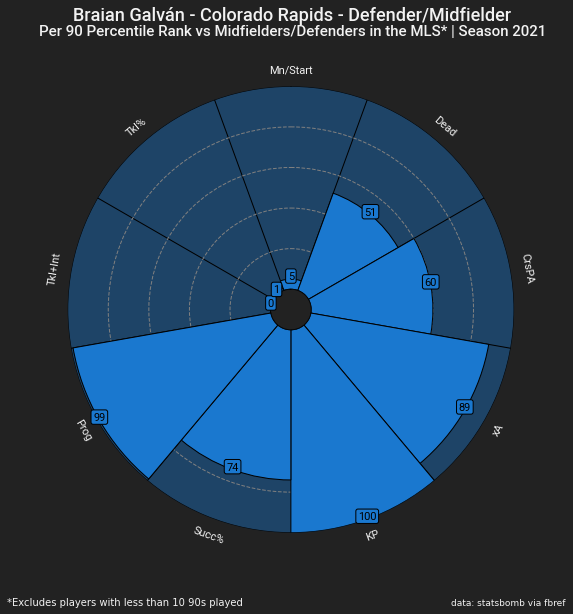

In [1714]:
# create params to map
params = list(df.columns)
params = params[6:]

# filter for player to analyze
player = df.loc[df['Player'] == 'Braian Galván'].reset_index()
player = list(player.loc[0])
player = player[7:]

# create list of values to plot and convert to percentiles
values = []
for x in range(len(params)):
    values.append(math.floor(stats.percentileofscore(df[params[x]], player[x])))
    
# load some fonts
font_normal = FontManager(("https://github.com/google/fonts/blob/main/apache/roboto/static/"
                           "Roboto-Regular.ttf?raw=true"))
font_italic = FontManager(("https://github.com/google/fonts/blob/main/apache/roboto/static/"
                           "Roboto-Italic.ttf?raw=true"))
font_bold = FontManager(("https://github.com/google/fonts/blob/main/apache/roboto/static/"
                         "Roboto-Medium.ttf?raw=true"))

# color of slices and text
slice_colors = ['#1A78CF'] * 9
text_color = ["#000000"] * 9 

# instantiate PyPizza class
baker = PyPizza(
    params=params,
    background_color='#222222',
    straight_line_color='#000000',
    straight_line_lw=1,
    last_circle_color='#000000',
    last_circle_lw=1,
    other_circle_lw=1,
    inner_circle_size=10
)

# plot pizza
fig, ax = baker.make_pizza(
    values,
    figsize=(8, 8.5),
    color_blank_space='same',
    slice_colors=slice_colors,
    value_colors=text_color,
    value_bck_colors=slice_colors,
    blank_alpha=0.4,
    kwargs_values=dict(
        color='#F2F2F', fontsize=11,
        fontproperties=font_normal.prop, zorder=3,
        bbox=dict(
            edgecolor='#000000', facecolor='conrflowerblue',
            boxstyle='round,pad=0.2', lw=1
        )
    ),
    kwargs_slices=dict(
        edgecolor='#000000', zorder=2, linewidth=1
    ),
    kwargs_params=dict(
        color='#F2F2F2', fontsize=11,
        fontproperties=font_normal.prop, va='center'
    )
)

# add title
fig.text(
    0.515, 0.975, 'Braian Galván - Colorado Rapids - Defender/Midfielder', size=18,
    fontproperties=font_bold.prop, color='#F2F2F2',
    ha='center')

# add subtitle
fig.text(
    0.515, 0.95, 
    'Per 90 Percentile Rank vs Midfielders/Defenders in the MLS* | Season 2021',
    size=15, fontproperties=font_bold.prop, color='#F2F2F2',
    ha='center'
)

# add credits
CREDIT_1 = 'data: statsbomb via fbref'

fig.text(
    0.99, 0.02, f'{CREDIT_1}', size=9,
    ha='right', color='#F2F2F2'
)


# add text
fig.text(
    0.02, 0.02, '*Excludes players with less than 10 90s played', color='#F2F2F2')

plt.savefig('galvan.png')

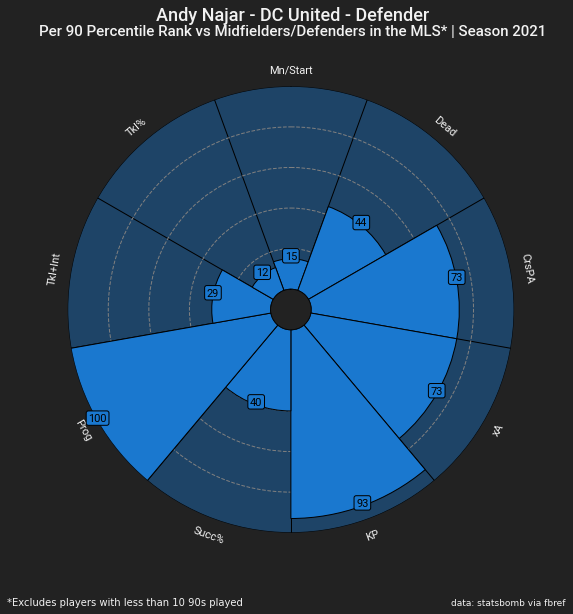

In [1715]:
# create params to map
params = list(df.columns)
params = params[6:]

# filter for player to analyze
player = df.loc[df['Player'] == 'Andy Najar'].reset_index()
player = list(player.loc[0])
player = player[7:]

# create list of values to plot and convert to percentiles
values = []
for x in range(len(params)):
    values.append(math.floor(stats.percentileofscore(df[params[x]], player[x])))
    
# load some fonts
font_normal = FontManager(("https://github.com/google/fonts/blob/main/apache/roboto/static/"
                           "Roboto-Regular.ttf?raw=true"))
font_italic = FontManager(("https://github.com/google/fonts/blob/main/apache/roboto/static/"
                           "Roboto-Italic.ttf?raw=true"))
font_bold = FontManager(("https://github.com/google/fonts/blob/main/apache/roboto/static/"
                         "Roboto-Medium.ttf?raw=true"))

# color of slices and text
slice_colors = ['#1A78CF'] * 9
text_color = ["#000000"] * 9 

# instantiate PyPizza class
baker = PyPizza(
    params=params,
    background_color='#222222',
    straight_line_color='#000000',
    straight_line_lw=1,
    last_circle_color='#000000',
    last_circle_lw=1,
    other_circle_lw=1,
    inner_circle_size=10
)

# plot pizza
fig, ax = baker.make_pizza(
    values,
    figsize=(8, 8.5),
    color_blank_space='same',
    slice_colors=slice_colors,
    value_colors=text_color,
    value_bck_colors=slice_colors,
    blank_alpha=0.4,
    kwargs_values=dict(
        color='#F2F2F', fontsize=11,
        fontproperties=font_normal.prop, zorder=3,
        bbox=dict(
            edgecolor='#000000', facecolor='conrflowerblue',
            boxstyle='round,pad=0.2', lw=1
        )
    ),
    kwargs_slices=dict(
        edgecolor='#000000', zorder=2, linewidth=1
    ),
    kwargs_params=dict(
        color='#F2F2F2', fontsize=11,
        fontproperties=font_normal.prop, va='center'
    )
)

# add title
fig.text(
    0.515, 0.975, 'Andy Najar - DC United - Defender', size=18,
    fontproperties=font_bold.prop, color='#F2F2F2',
    ha='center')

# add subtitle
fig.text(
    0.515, 0.95, 
    'Per 90 Percentile Rank vs Midfielders/Defenders in the MLS* | Season 2021',
    size=15, fontproperties=font_bold.prop, color='#F2F2F2',
    ha='center'
)

# add credits
CREDIT_1 = 'data: statsbomb via fbref'

fig.text(
    0.99, 0.02, f'{CREDIT_1}', size=9,
    ha='right', color='#F2F2F2'
)


# add text
fig.text(
    0.02, 0.02, '*Excludes players with less than 10 90s played', color='#F2F2F2')

plt.savefig('najar.png')

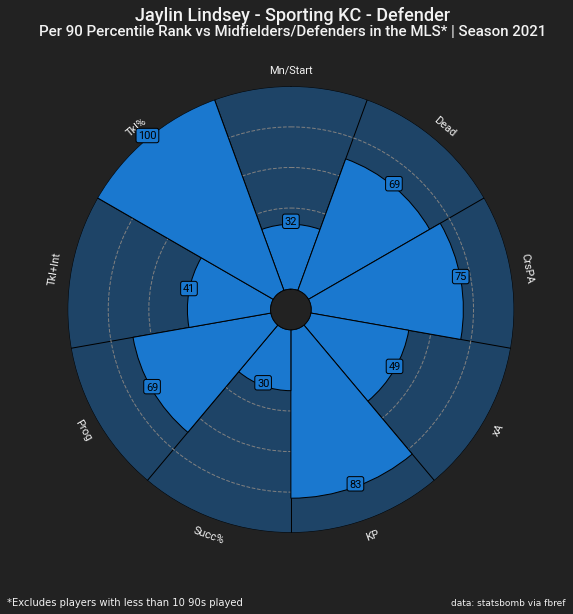

In [1716]:
# create params to map
params = list(df.columns)
params = params[6:]

# filter for player to analyze
player = df.loc[df['Player'] == 'Jaylin Lindsey'].reset_index()
player = list(player.loc[0])
player = player[7:]

# create list of values to plot and convert to percentiles
values = []
for x in range(len(params)):
    values.append(math.floor(stats.percentileofscore(df[params[x]], player[x])))
    
# load some fonts
font_normal = FontManager(("https://github.com/google/fonts/blob/main/apache/roboto/static/"
                           "Roboto-Regular.ttf?raw=true"))
font_italic = FontManager(("https://github.com/google/fonts/blob/main/apache/roboto/static/"
                           "Roboto-Italic.ttf?raw=true"))
font_bold = FontManager(("https://github.com/google/fonts/blob/main/apache/roboto/static/"
                         "Roboto-Medium.ttf?raw=true"))

# color of slices and text
slice_colors = ['#1A78CF'] * 9
text_color = ["#000000"] * 9 

# instantiate PyPizza class
baker = PyPizza(
    params=params,
    background_color='#222222',
    straight_line_color='#000000',
    straight_line_lw=1,
    last_circle_color='#000000',
    last_circle_lw=1,
    other_circle_lw=1,
    inner_circle_size=10
)

# plot pizza
fig, ax = baker.make_pizza(
    values,
    figsize=(8, 8.5),
    color_blank_space='same',
    slice_colors=slice_colors,
    value_colors=text_color,
    value_bck_colors=slice_colors,
    blank_alpha=0.4,
    kwargs_values=dict(
        color='#F2F2F', fontsize=11,
        fontproperties=font_normal.prop, zorder=3,
        bbox=dict(
            edgecolor='#000000', facecolor='conrflowerblue',
            boxstyle='round,pad=0.2', lw=1
        )
    ),
    kwargs_slices=dict(
        edgecolor='#000000', zorder=2, linewidth=1
    ),
    kwargs_params=dict(
        color='#F2F2F2', fontsize=11,
        fontproperties=font_normal.prop, va='center'
    )
)

# add title
fig.text(
    0.515, 0.975, 'Jaylin Lindsey - Sporting KC - Defender', size=18,
    fontproperties=font_bold.prop, color='#F2F2F2',
    ha='center')

# add subtitle
fig.text(
    0.515, 0.95, 
    'Per 90 Percentile Rank vs Midfielders/Defenders in the MLS* | Season 2021',
    size=15, fontproperties=font_bold.prop, color='#F2F2F2',
    ha='center'
)

# add credits
CREDIT_1 = 'data: statsbomb via fbref'

fig.text(
    0.99, 0.02, f'{CREDIT_1}', size=9,
    ha='right', color='#F2F2F2'
)


# add text
fig.text(
    0.02, 0.02, '*Excludes players with less than 10 90s played', color='#F2F2F2')

plt.savefig('lindsey.png')

In [1717]:
dfp = df[df['Player'].isin(['Adam Lundqvist', 'Jaylin Lindsey', 'Andy Najar', 'Braian Galván', 'Raheem Edwards'])]
dfp

,index,Player,Squad,Pos,Age,90s,Mn/Start,Dead,CrsPA,xA,KP,Succ%,Prog,Tkl+Int,Tkl%
238,486,Adam Lundqvist,Houston Dynamo,DF,26.0,21.6,84.0,9.49,1.29,0.11,1.04,55.2,4.65,3.81,40.5
228,471,Jaylin Lindsey,Sporting KC,DF,20.0,10.2,84.0,8.73,0.51,0.05,1.10,52.9,4.75,2.54,78.6
304,603,Andy Najar,D.C. United,DF,27.0,21.3,80.0,5.49,0.48,0.10,1.43,57.1,9.52,2.38,28.6
156,303,Braian Galván,Colorado Rapids,DFMF,20.0,13.4,74.0,6.57,0.36,0.14,2.86,69.2,8.57,0.71,0.0
130,253,Raheem Edwards,Los Angeles FC,DFMF,25.0,15.3,70.0,6.41,0.33,0.43,1.67,50.0,5.00,3.67,37.5


In [1718]:
dfp.to_csv('mls-player-shortlist.csv')